<img style="float: right; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="50" /> 
    
    
### <font color='navy'> Modelos no Lineales para Pronósticos. </font>

**Nombres:**
> `Cárdenas Gallardo Paula Daniela` | `733720` <br> `Haces López José Manuel` | `734759` <br> `Villa Domínguez Paulo Adrián` | `733773`

**Fecha:** Jueves 11 de Mayo de 2023
    
**Profesor:** Óscar David Jaramillo Zuluaga.
    
**Link Github**: [github.com](https://github.com/paucardenasg/Proyecto_MNLP)

# <font color='maroon'> Proyecto Final </font>

In [1]:
# Librerías
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras import layers
from pmdarima.arima import auto_arima
from keras.utils import to_categorical
from sklearn.naive_bayes import GaussianNB
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler

# Funciones y Clases
from Utils_Multi import *
from Utils_Lineal import *
from Utils_Clasificacion import *
from Utils_Univariado import NN_maker

# Filtrando las advertencias
warnings.filterwarnings('ignore')

In [2]:
# Carga de datos
data = pd.read_csv('./Data/dataset.csv')
# Eliminando la columna de index y Unit
data.drop(columns=['SN', 'Unit'], inplace=True)
# Poniendo el date a formato de fecha
data['Date'] = pd.to_datetime(data['Date'])
# Poniendo la fecha como str
data['Fecha_Str'] = data['Date'].dt.strftime('%Y-%m-%d')
# Cambiando el nombre de las columnas a español
data.rename(columns={'Date':'Fecha', 'Commodity':'Producto', 'Minimum':'Mínimo', 'Maximum':'Máximo', 'Average':'Promedio'}, inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Cargando el dataset del cambio de Rupia Nepali a Pesos
data_cambio = pd.read_excel('./Data/CambioMoneda.xlsx')
# Poniendo Fecha en formato de fech
data_cambio['Fecha'] = pd.to_datetime(data_cambio['Fecha'])
# Quitando la hora de la fecha
data_cambio['Fecha'] = data_cambio['Fecha'].dt.date
# Poniendo la fecha como str
data_cambio['Fecha_Str'] = data_cambio['Fecha'].astype(str)

# --------------------------------------------------------------------------------------------------------------------

# Obtener las clases de productos
productos_clase = data[['Producto']]
productos_clase = productos_clase.drop_duplicates()
# Tomar solo la primera palabra del valor de la columna de producto
productos_clase['Clase'] = productos_clase['Producto'].str.split(' ').str[0]
productos_clase['Clase'] = productos_clase['Clase'].str.split('(').str[0]

# Mergeando los datos con la clase de producto
data = data.merge(productos_clase, on='Producto')

# --------------------------------------------------------------------------------------------------------------------

# Juntando los dos datasets de tipo de cambio a pesos
data = data.merge(data_cambio.drop(columns=['Fecha']), on='Fecha_Str')

# --------------------------------------------------------------------------------------------------------------------

# Dataset con el precio del dolar
dolar = pd.read_excel('./Data/PrecioDolar.xlsx')
dolar['Fecha'] = pd.to_datetime(dolar['Fecha'])
# Quitando la hora de la fecha
dolar['Fecha'] = dolar['Fecha'].dt.date
# Poniendo la fecha como str
dolar['Fecha_Str'] = dolar['Fecha'].astype(str)

# Mergeando los datos con el precio del dolar
data = data.merge(dolar.drop(columns=['Fecha']), on='Fecha_Str')

# --------------------------------------------------------------------------------------------------------------------

# Multiplicando el precio por el cambio de moneda
data['Mínimo'] = np.round(data['Mínimo'] * data['Valor'], decimals=4)
data['Máximo'] = np.round(data['Máximo'] * data['Valor'], decimals=4)
data['Promedio'] = np.round(data['Promedio'] * data['Valor'], decimals=4)
# Eliminar la columna de valor
data.drop(columns=['Valor'], inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Sacando una columna con el año
data['Year'] = data['Fecha'].dt.year

# Dataset con la inflación
inflacion = pd.read_excel('./Data/Inflacion.xlsx')
data = data.merge(inflacion, on='Year')

# --------------------------------------------------------------------------------------------------------------------

# Agregando el porcentaje de desempleo
desempleo = pd.read_excel('./Data/Desempleo.xlsx')
data = data.merge(desempleo, on='Year')

# --------------------------------------------------------------------------------------------------------------------

# Poniendo la fecha como indice
data.set_index('Fecha', inplace=True)

# Ordenando los datos por fecha y por producto
data.sort_values(by=['Fecha', 'Producto'], inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Ordenando las columnas
data = data[['Producto', 'Clase', 'Mínimo', 'Máximo', 'Promedio', 'Inflacion', 'Precio_Dolar', 'Desempleo']]

data.head()

,Producto,Clase,Mínimo,Máximo,Promedio,Inflacion,Precio_Dolar,Desempleo
Fecha,,,,,,,,
2013-06-16,Apple(Jholey),Apple,13.6746,16.4096,15.0421,9.04,90.456,10.5
2013-06-16,Asparagus,Asparagus,13.6746,20.5120,17.0933,9.04,90.456,10.5
2013-06-16,Bamboo Shoot,Bamboo,6.8373,8.2048,7.5211,9.04,90.456,10.5
2013-06-16,Banana,Banana,9.5723,10.9397,10.2560,9.04,90.456,10.5
2013-06-16,Bitter Gourd,Bitter,1.9145,2.1879,2.0512,9.04,90.456,10.5


## <font color='maroon'> EDA </font>

In [3]:
# Conocer las variables

# Tipo de cada variable
print(f'\n+ Tipo de datos por columna: \n{data.dtypes}')

# Conteo de valores nulos
print(f'\n+ Cantidad de nulos por columna: \n{data.isnull().sum()}')

# Valores únicos
print(f'\n+ Valores únicos por columna: \n{data.nunique()}')


+ Tipo de datos por columna: 
Producto         object
Clase            object
Mínimo          float64
Máximo          float64
Promedio        float64
Inflacion       float64
Precio_Dolar    float64
Desempleo       float64
dtype: object

+ Cantidad de nulos por columna: 
Producto        0
Clase           0
Mínimo          0
Máximo          0
Promedio        0
Inflacion       0
Precio_Dolar    0
Desempleo       0
dtype: int64

+ Valores únicos por columna: 
Producto          132
Clase              84
Mínimo          58427
Máximo          57747
Promedio        66988
Inflacion           9
Precio_Dolar     1779
Desempleo           6
dtype: int64


In [4]:
# Datos estadísticos de las variables
data.describe()

,Mínimo,Máximo,Promedio,Inflacion,Precio_Dolar,Desempleo
count,169641.000000,169641.000000,169641.000000,169641.000000,169641.000000,169641.000000
mean,14.301900,15.737049,15.019474,6.151778,107.004676,11.083907
std,13.273342,14.085266,13.666749,1.982469,7.480348,0.972946
min,0.171300,0.807100,0.673600,3.630000,90.456000,10.400000
25%,6.069700,6.960500,6.504800,4.090000,100.920000,10.500000
50%,9.813700,11.037100,10.408900,5.570000,106.320000,10.600000
75%,16.890700,18.590400,17.743300,8.360000,113.370000,10.700000
max,316.025300,351.139200,333.582200,9.040000,122.138400,13.100000


In [5]:
# Mostrando fechas de inicio y fin de los datos, puras fechas sin hora
print('Fecha de inicio: ', data.index.min().date())
print('Fecha de fin: ', data.index.max().date())

Fecha de inicio:  2013-06-16
Fecha de fin:  2021-05-11


In [6]:
# Productos
tipos_de_productos = data['Producto'].unique()
print(f'Cantidad de Productos: {len(tipos_de_productos)}')

Cantidad de Productos: 132


In [7]:
# Porcentaje que representa cada producto
porcentaje = data['Producto'].value_counts(normalize=True).reset_index().sort_values(by='Producto', ascending=False)
# Multiplicando por 100 para obtener el porcentaje
porcentaje['Producto'] = np.round(porcentaje['Producto'] * 100, decimals=3)
# Haciendo una suma acumulativa
porcentaje['Cum_Sum'] = porcentaje['Producto'].cumsum()
porcentaje

,index,Producto,Cum_Sum
0,Ginger,1.385,1.385
1,Cauli Local,1.385,2.770
2,Cabbage(Local),1.384,4.154
3,Chilli Dry,1.384,5.538
4,Raddish White(Local),1.384,6.922
...,...,...,...
127,Maize,0.013,99.975
128,Mango(Calcutte),0.012,99.987
129,Sweet Lime,0.008,99.995
130,Musk Melon,0.004,99.999


___
## <font color='maroon'> Modelos Lineales </font>

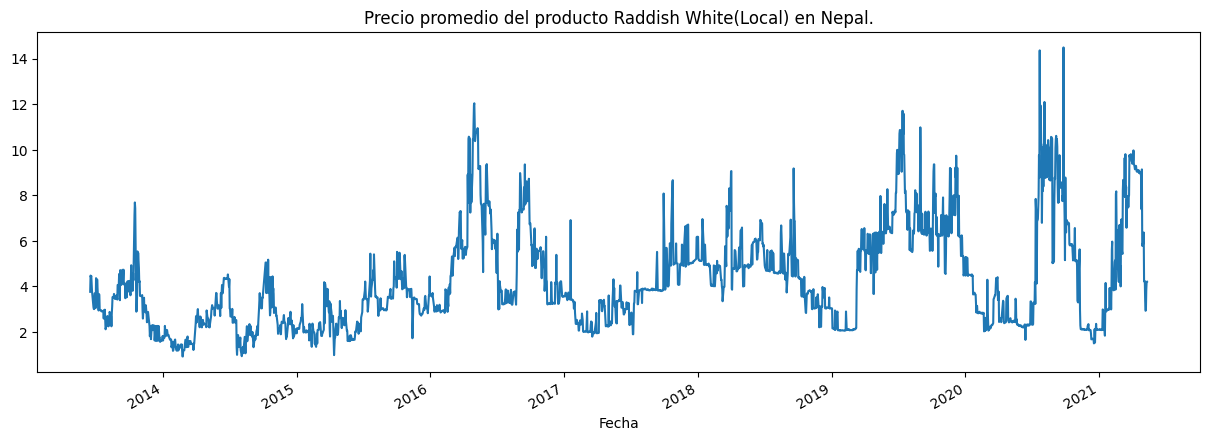

In [8]:
# Poniendo un seed para que siempre se obtenga el mismo resultado
np.random.seed(21)

# Random choice para seleccionar un producto al azar
producto = np.random.choice(tipos_de_productos)

# Graficando el promedio del producto seleccionado
data[data['Producto'] == producto]['Promedio'].plot(figsize=(15, 5), title=f'Precio promedio del producto {producto} en Nepal.')
plt.show()

In [9]:
# Guardar la serie de tiempo de interés
data_prod = pd.DataFrame(data.loc[data.Producto == producto]['Promedio'])

In [10]:
# Ver si los meses están completos
print(f'Primera fecha: {data_prod.index[0]}\nÚltima fecha: {data_prod.index[-1]}')

Primera fecha: 2013-06-16 00:00:00
Última fecha: 2021-05-11 00:00:00


In [11]:
data_lin = data_prod.drop(['2013-06-16', '2013-06-17', '2013-06-18', '2013-06-19', '2013-06-20', '2013-06-21',
                            '2013-06-25', '2013-06-26', '2013-06-27', '2013-06-28', '2013-06-30', '2021-05-01',
                            '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07',
                            '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11'])

In [12]:
# Obtener un promedio mensual de los precios en lugar de mantener datos diarios
data_lin = data_lin.resample('M').mean()
data_lin

,Promedio
Fecha,
2013-07-31,3.027983
2013-08-31,3.036414
2013-09-30,4.105971
2013-10-31,4.619688
2013-11-30,2.824422
...,...
2020-12-31,1.961887
2021-01-31,2.640642
2021-02-28,5.024932


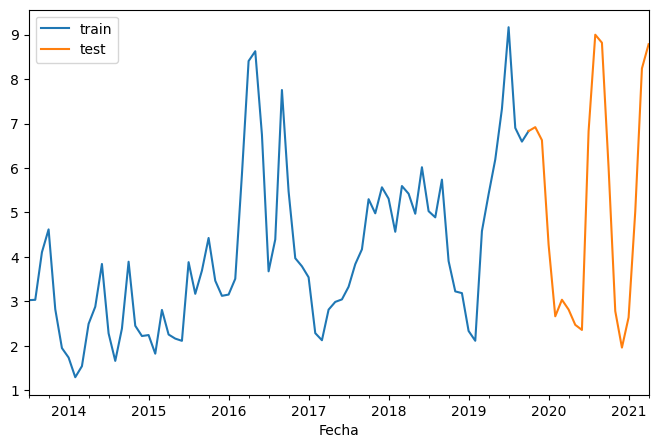

In [13]:
# Dividir en datos de entrenamiento (80%) y prueba (20%)
div = int(data_lin.shape[0]*.8)
train = data_lin[:div+1]
test = data_lin[div:]

# Visualizar partición entrenamiento - prueba
fig, ax = plt.subplots(figsize=(10, 5))
train.plot(figsize=(8,5), ax=ax,)
test.plot(figsize=(8,5), ax=ax)
ax.legend(labels = ['train', 'test'])
plt.show()

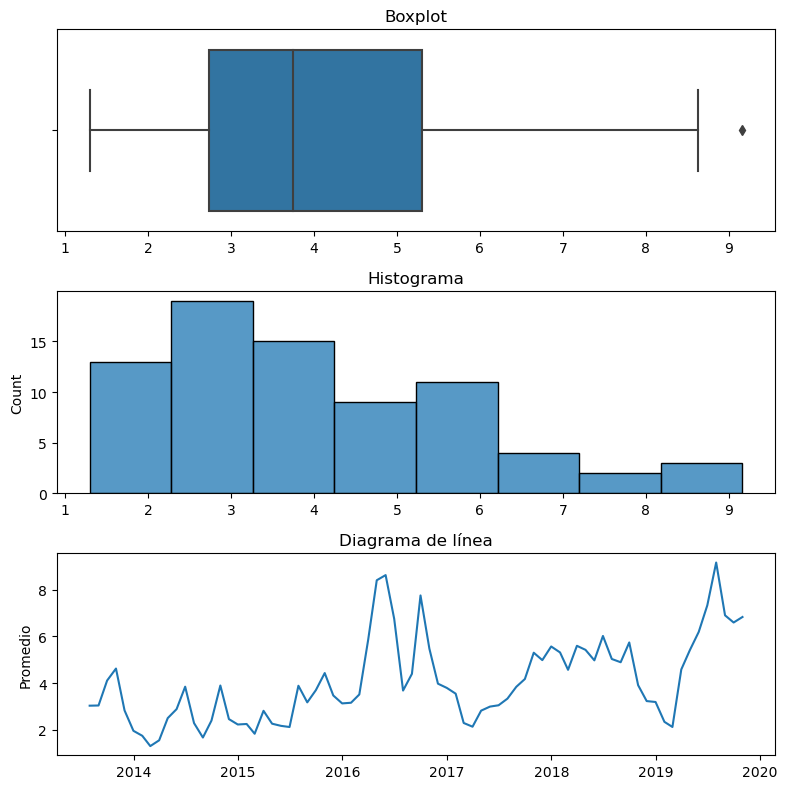

In [14]:
# Visualizar la distribución de la serie de tiempo
fig, ax = plt.subplots(3, 1, figsize=(8, 8))
sns.boxplot(x=train['Promedio'], ax=ax[0])
sns.histplot(x=train['Promedio'], ax=ax[1])
sns.lineplot(data=train['Promedio'], ax=ax[2])
ax[0].set(title='Boxplot', xlabel=None)
ax[1].set(title='Histograma', xlabel=None)
ax[2].set(title='Diagrama de línea', xlabel=None)
plt.tight_layout()

Dado que la serie no tiene una distribución normal, se transformará.

In [15]:
def transform_series(train_data, method, plot=True):
    data_transformations = train_data.copy()
    # Escalamientos
    if method == 'min_max':
        min_max = MinMaxScaler()
        data_transformations['min_max'] = min_max.fit_transform(data_transformations.values.reshape(-1, 1))
    elif method == 'standard':
        scaler = StandardScaler()
        data_transformations['standar'] = scaler.fit_transform(data_transformations.values.reshape(-1, 1))
    elif method == 'log':
        data_transformations['log'] = np.log(data_transformations)
    elif method == 'box_cox':
        data_transformations['box_cox'] = power_transform(data_transformations.values.reshape(-1, 1), method='box-cox')
    else:
        raise ValueError('Método de transformación no válido.')
    print(f'Transformación {method} completada.')
    if plot:
        fig, ax = plt.subplots(3, 1, figsize=(8, 8))
        sns.boxplot(x=data_transformations[method], ax=ax[0])
        sns.histplot(x=data_transformations[method], ax=ax[1])
        sns.lineplot(data=data_transformations[method], ax=ax[2])
        ax[0].set(title="Boxplot", xlabel=None)
        ax[1].set(title="Histograma", xlabel=None)
        ax[2].set(title="Diagrama de línea", xlabel=None)
        plt.xticks(rotation=90)
        plt.tight_layout()
    return data_transformations

Transformación log completada.


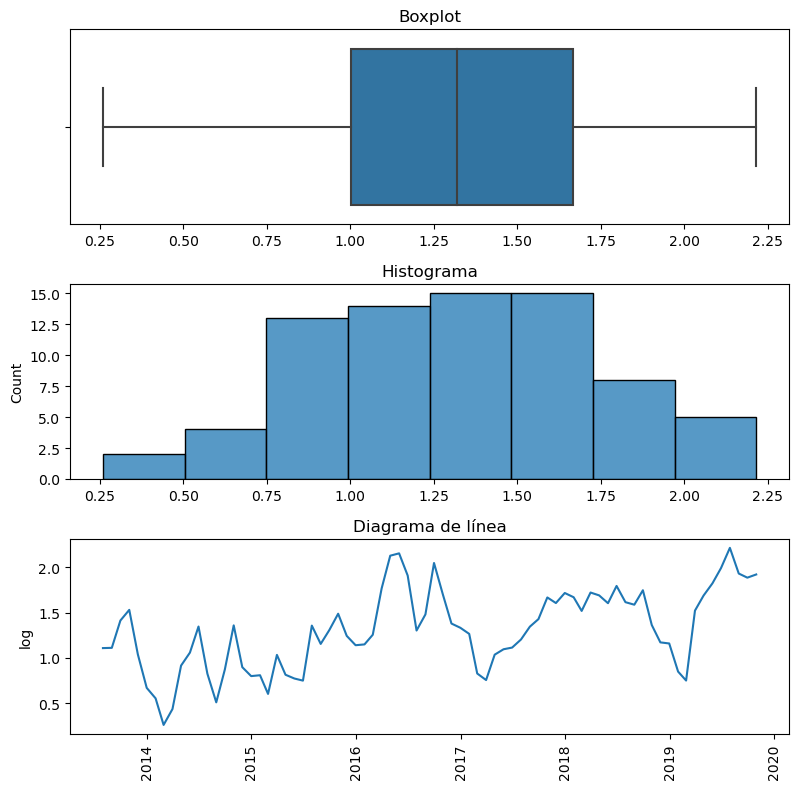

In [16]:
train = transform_series(train, 'log')

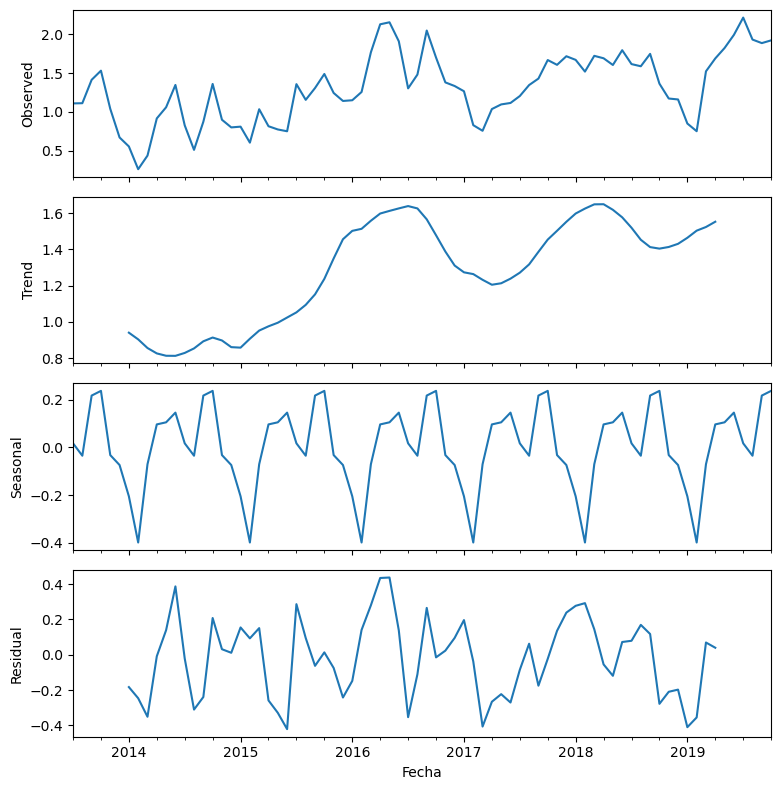

In [17]:
resultados = seasonal_decompose(train['log'], model='additive', period=12)

# Gráfica
fig, ax = plt.subplots(4, sharex=True, figsize=(8, 8))
resultados.observed.plot(ax=ax[0])   # Datos originales
ax[0].set_ylabel('Observed')
resultados.trend.plot(ax=ax[1])      # Tendencia
ax[1].set_ylabel('Trend')
resultados.seasonal.plot(ax=ax[2])   # Estacionalidad
ax[2].set_ylabel('Seasonal')
resultados.resid.plot(ax=ax[3])      # Residuos
ax[3].set_ylabel('Residual')
fig.tight_layout()

La serie de tiempo muestra una clara estacionalidad anual (cada 12 meses), así como una ligera tendencia a la alcista que era de esperarse por la inflación.

In [18]:
# Función para graficar autocorrelación
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))
    ax1 = f.add_subplot(121)
    plot_acf(data, zero=False, ax=ax1, **kwargs)
    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)
    plt.show()
    
# Función para realizar la prueba de Dikcey-Fuller
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

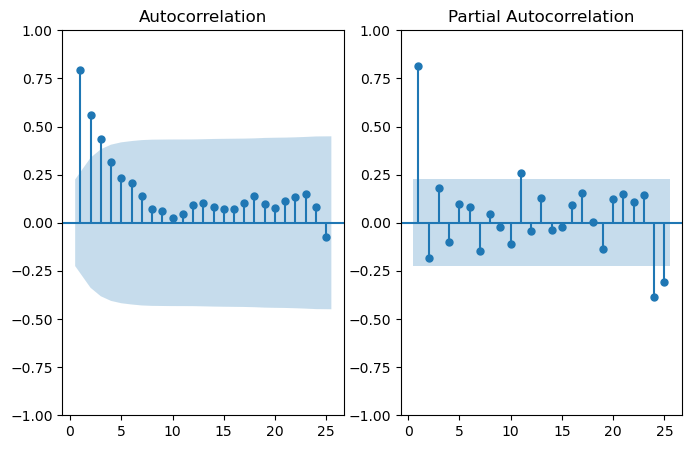

In [19]:
# Funciones de autocorrelación
plot_acf_pacf(train['log'], {'lags':25})

In [20]:
# Prueba de Dikcey-Fuller para ver si la serie es estacionaria
adf_test(train['log'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.216279
p-value                         0.200390
#Lags Used                      2.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64
Non-stationary


Como la serie no es estacionaria, se probarán diferenciaciones de primer y segundo orden.

In [21]:
# Funciones de autocorrelación con diferenciación
diff1 = train['log'].diff().dropna()
print('ADF para derivada primer orden\n')
adf_test(diff1)

diff2 = train['log'].diff().diff().dropna()
print('ADF para derivada segundo orden\n')
adf_test(diff2)

ADF para derivada primer orden

Results of Dickey-Fuller Test:
Test Statistic                -7.673438e+00
p-value                        1.571432e-11
#Lags Used                     1.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64
Stationary
ADF para derivada segundo orden

Results of Dickey-Fuller Test:
Test Statistic                -7.560259e+00
p-value                        3.023241e-11
#Lags Used                     4.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64
Stationary


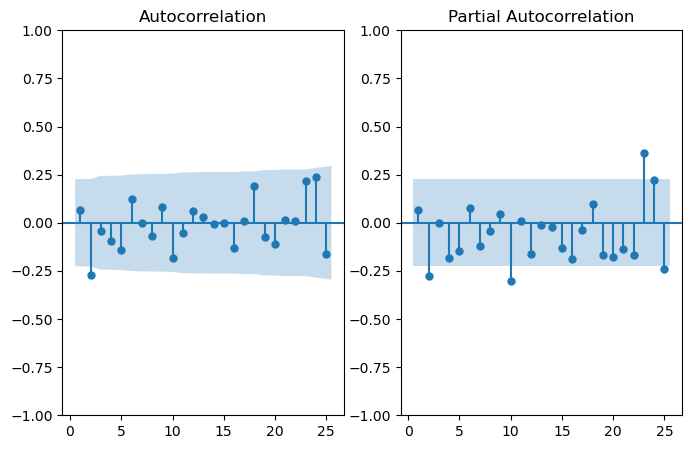

In [22]:
# Funciones de autocorrelación con diferenciación
plot_acf_pacf(diff1, {'lags':25})

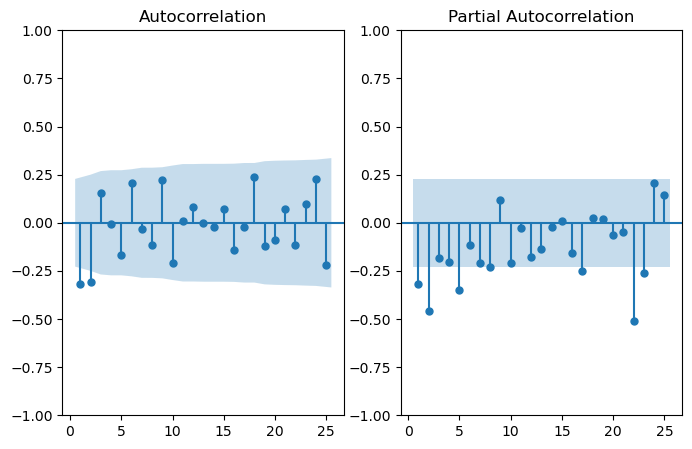

In [23]:
# Funciones de autocorrelación con diferenciación de segundo orden
plot_acf_pacf(diff2, {'lags':25})

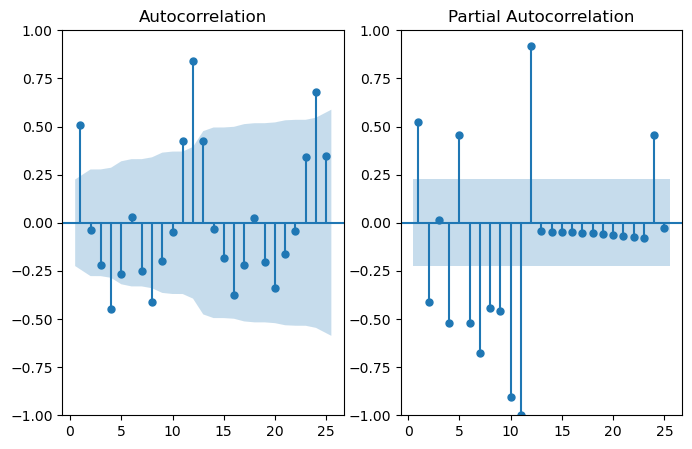

In [24]:
# Parte estacional
plot_acf_pacf(resultados.seasonal, {'lags':25})

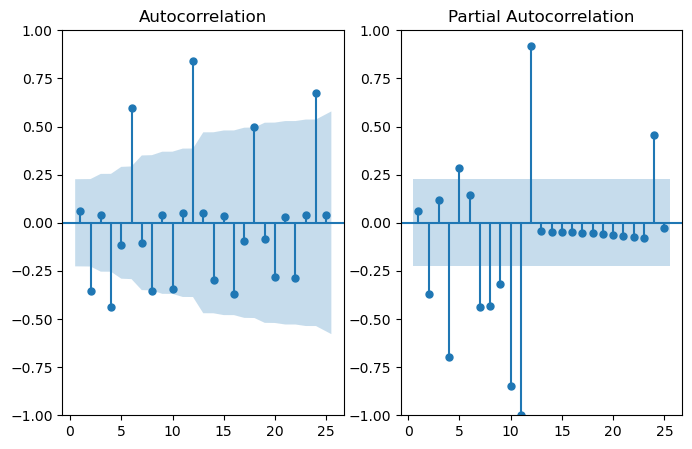

In [25]:
# Parte estacional con diferenciación
plot_acf_pacf(resultados.seasonal.diff().dropna(), {'lags':25})

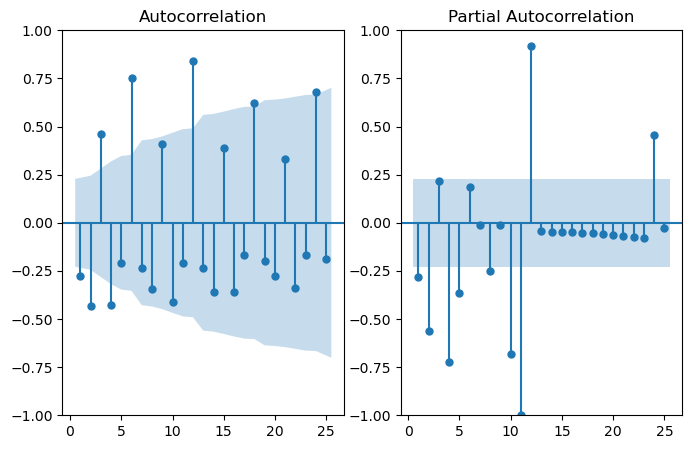

In [26]:
# Parte estacional con diferenciación
plot_acf_pacf(resultados.seasonal.diff().diff().dropna(), {'lags':25})

**Propuestas de modelos:**
Después de analizar los datos, se considera que podrían funcionar los siguientes modelos:
+ $ARIMA(1, 0, 3)$ porque el primer *lag* es significativo en la PACF y los primeros tres *lags* son significativos en la ACF
+ $ARIMA(2, 2, 2)$ porque los dos primeros *lags* son sifnigicantes en ambas gráficas (PACF y ACF), además de la diferenciación de segundo orden
+ $ARIMA(2, 1, 2)$ porque los dos primeros *lags* son sifnigicantes en ambas gráficas (PACF y ACF), además de la diferenciación

Siguiendo esta lógica, también se probarán las siguientes combinaciones:
+ $ARIMA(1, 0, 2)$
+ $ARIMA(1, 0, 1)$
+ $ARIMA(1, 2, 2)$
+ $ARIMA(2, 2, 1)$
+ $ARIMA(1, 2, 1)$
+ $ARIMA(1, 1, 2)$
+ $ARIMA(2, 1, 1)$
+ $ARIMA(1, 1, 1)$

Además se verá qué modelo sugiere el método `autoarima`:

In [28]:
# Crear modelo
auto_model = auto_arima(train['log'],
                        start_p=1,
                        start_q=1,
                        test='adf',                   # para encontrar el 'd' óptimo
                        information_criterion='aic',  # se buscará reducir el AIC
                        m=1,             
                        d=1,          
                        seasonal=True,   
                        start_P=0, 
                        D=None, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25.736, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24.782, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26.459, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.077, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22.896, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.144 seconds


**Modelado**

In [29]:
# Modelo 1
arima_model1 = ARIMA(train['log'], order=(1, 0, 3))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(1, 0, 3)   Log Likelihood                  -4.475
Date:                Wed, 10 May 2023   AIC                             20.950
Time:                        14:57:54   BIC                             34.935
Sample:                    07-31-2013   HQIC                            26.539
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3251      0.159      8.319      0.000       1.013       1.637
ar.L1          0.8113      0.149      5.447      0.000       0.519       1.103
ma.L1          0.1898      0.183      1.037      0.3

In [30]:
# Modelo 2
arima_model2 = ARIMA(train['log'], order=(2, 2, 2))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(2, 2, 2)   Log Likelihood                  -9.902
Date:                Wed, 10 May 2023   AIC                             29.803
Time:                        14:57:54   BIC                             41.324
Sample:                    07-31-2013   HQIC                            34.399
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1011      0.438     -0.231      0.817      -0.959       0.757
ar.L2         -0.2468      0.134     -1.838      0.066      -0.510       0.016
ma.L1         -0.7878      3.147     -0.250      0.8

In [31]:
# Modelo 3
arima_model3 = ARIMA(train['log'], order=(2, 1, 2))
model3 = arima_model3.fit()
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  -4.892
Date:                Wed, 10 May 2023   AIC                             19.784
Time:                        14:57:54   BIC                             31.372
Sample:                    07-31-2013   HQIC                            24.411
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4072      0.381      1.068      0.285      -0.340       1.154
ar.L2          0.1385      0.355      0.390      0.697      -0.558       0.835
ma.L1         -0.3878      0.350     -1.108      0.2

In [32]:
# Modelo 4
arima_model4 = ARIMA(train['log'], order=(1, 0, 2))
model4 = arima_model4.fit()
print(model4.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  -4.489
Date:                Wed, 10 May 2023   AIC                             18.977
Time:                        14:57:54   BIC                             30.631
Sample:                    07-31-2013   HQIC                            23.635
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3230      0.154      8.605      0.000       1.022       1.624
ar.L1          0.7938      0.125      6.369      0.000       0.550       1.038
ma.L1          0.2029      0.175      1.157      0.2

In [33]:
# Modelo 5
arima_model5 = ARIMA(train['log'], order=(1, 0, 1))
model5 = arima_model5.fit()
print(model5.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  -5.064
Date:                Wed, 10 May 2023   AIC                             18.128
Time:                        14:57:55   BIC                             27.451
Sample:                    07-31-2013   HQIC                            21.854
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3164      0.129     10.229      0.000       1.064       1.569
ar.L1          0.6782      0.109      6.230      0.000       0.465       0.892
ma.L1          0.3564      0.138      2.590      0.0

In [34]:
# Modelo 6
arima_model6 = ARIMA(train['log'], order=(1, 2, 2))
model6 = arima_model6.fit()
print(model6.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 -11.297
Date:                Wed, 10 May 2023   AIC                             30.594
Time:                        14:57:55   BIC                             39.811
Sample:                    07-31-2013   HQIC                            34.271
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5077      0.425     -1.194      0.233      -1.341       0.326
ma.L1         -0.3105      4.378     -0.071      0.943      -8.891       8.270
ma.L2         -0.6880      2.885     -0.238      0.8

In [35]:
# Modelo 7
arima_model7 = ARIMA(train['log'], order=(2, 2, 1))
model7 = arima_model7.fit()
print(model7.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  -9.949
Date:                Wed, 10 May 2023   AIC                             27.898
Time:                        14:57:55   BIC                             37.114
Sample:                    07-31-2013   HQIC                            31.575
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0934      0.128      0.729      0.466      -0.158       0.344
ar.L2         -0.2660      0.122     -2.181      0.029      -0.505      -0.027
ma.L1         -0.9995      6.105     -0.164      0.8

In [36]:
# Modelo 8
arima_model8 = ARIMA(train['log'], order=(1, 2, 1))
model8 = arima_model8.fit()
print(model8.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -12.675
Date:                Wed, 10 May 2023   AIC                             31.350
Time:                        14:57:55   BIC                             38.262
Sample:                    07-31-2013   HQIC                            34.107
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0793      0.131      0.608      0.543      -0.176       0.335
ma.L1         -0.9990      3.732     -0.268      0.789      -8.313       6.315
sigma2         0.0781      0.293      0.266      0.7

In [37]:
# Modelo 9
arima_model9 = ARIMA(train['log'], order=(1, 1, 2))
model9 = arima_model9.fit()
print(model9.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  -5.051
Date:                Wed, 10 May 2023   AIC                             18.103
Time:                        14:57:55   BIC                             27.372
Sample:                    07-31-2013   HQIC                            21.804
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5444      0.164      3.321      0.001       0.223       0.866
ma.L1         -0.5104      0.171     -2.994      0.003      -0.845      -0.176
ma.L2         -0.3749      0.137     -2.743      0.0

In [38]:
# Modelo 10
arima_model10 = ARIMA(train['log'], order=(2, 1, 1))
model10 = arima_model10.fit()
print(model10.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  -7.293
Date:                Wed, 10 May 2023   AIC                             22.587
Time:                        14:57:56   BIC                             31.857
Sample:                    07-31-2013   HQIC                            26.288
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0537      0.426     -0.126      0.900      -0.888       0.781
ar.L2         -0.2626      0.118     -2.230      0.026      -0.493      -0.032
ma.L1          0.1505      0.443      0.340      0.7

In [39]:
# Modelo 11
arima_model11 = ARIMA(train['log'], order=(1, 1, 1))
model11 = arima_model11.fit()
print(model11.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                   76
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -8.913
Date:                Wed, 10 May 2023   AIC                             23.825
Time:                        14:57:56   BIC                             30.778
Sample:                    07-31-2013   HQIC                            26.601
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5328      0.407     -1.311      0.190      -1.330       0.264
ma.L1          0.7054      0.353      1.996      0.046       0.013       1.398
sigma2         0.0742      0.012      6.254      0.0

In [40]:
# Modelo 12
model12 = SARIMAX(train['log'], order=(1, 1, 1), seasonal_order=(2, 0, 1, 12))
sarima1 = model12.fit()
sarima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                log   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                  -3.241
Date:                            Wed, 10 May 2023   AIC                             18.482
Time:                                    14:57:56   BIC                             32.387
Sample:                                07-31-2013   HQIC                            24.034
                                     - 10-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8335      0.160     -5.198      0.000      -1.148      -0.519
ma.L1          0.9442      0.091     10.423      0.000       0.767       1.122
ar.S.L12       0.6591      0.238      2.765      0.006       0.192       1.126
ar.S.L24       0.2951      0.153      1.931      0.053      -0.004       0.595
ma.S.L12      -0.7699      0.390     -1.973      0.049      -1.535      -0.005
sigma2         0.0557      0.016      3.438      0.001       0.024       0.088
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.86   Prob(JB):                         0.98
Heteroskedasticity (H):               0.54   Skew:                             0.01
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# Modelo 13
model13 = SARIMAX(train['log'], order=(0, 1, 0), seasonal_order=(1, 0, 1, 12))
sarima2 = model13.fit()
sarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  log   No. Observations:                   76
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                  -6.494
Date:                              Wed, 10 May 2023   AIC                             18.987
Time:                                      14:57:57   BIC                             25.940
Sample:                                  07-31-2013   HQIC                            21.764
                                       - 10-31-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9996      0.196      5.102      0.000       0.616       1.384
ma.S.L12      -0.9839      3.948     -0.249      0.803      -8.721       6.753
sigma2         0.0591      0.222      0.266      0.790      -0.376       0.494
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.62   Prob(JB):                         0.96
Heteroskedasticity (H):               0.49   Skew:                             0.06
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Ahora, se analizarán los resultados**

In [42]:
# Función para separar los valores del resumen del modelo
def extract_values(text):
    values = {}
    lines = text.split("\n")
    for line in lines:
        line = line.strip()
        if line:
            words = line.split()
            if len(words) >= 2:
                try:
                    value = float(words[-1])
                    key = " ".join(words[:-1])
                    values[key] = value
                except ValueError:
                    pass
    return values

In [43]:
# Crear una lista con todos los resultados de los modelos
results = []
for i in [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, sarima1, sarima2]:
    results.append(extract_values(i.summary().as_text()))

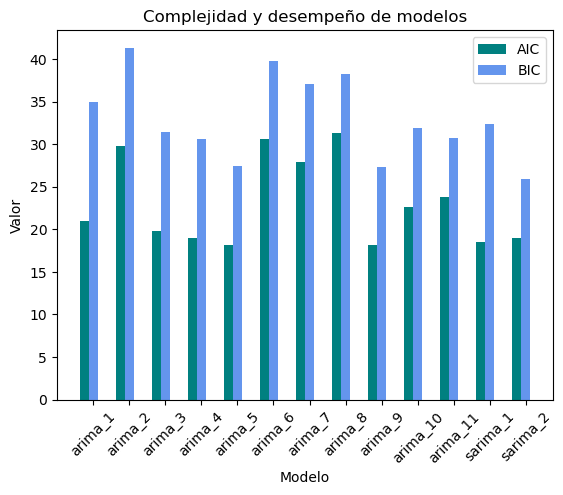

In [44]:
# Convertir a DataFrame
r = pd.DataFrame(results)


# Visualizar
br1 = np.arange(len(list(r.iloc[:, 0])))
br2 = [x + 0.25 for x in br1]
plt.bar(br1, r.iloc[:, 2], color ='teal', width = 0.25, label ='AIC')
plt.bar(br2, r.iloc[:, 3], color ='cornflowerblue', width = 0.25, label ='BIC')
plt.title('Complejidad y desempeño de modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.xticks([r + 0.25 for r in range(13)], ['arima_1', 'arima_2', 'arima_3', 'arima_4', 'arima_5', 'arima_6', 'arima_7',
                                           'arima_8', 'arima_9', 'arima_10', 'arima_11', 'sarima_1', 'sarima_2'],
           rotation=45)
plt.legend()
plt.show()

**_`Observaciones:`_** <br>
+ **Log-Likelihood**: conforme el valor de la verosimilitud sea mayor, es mejor. En este caso, todos los modelos estuvieron entre $-3$ y $-12$. El mejor fue el model 12 (primer SARIMAX). 

+ **Criterio de información de Akaike**: si este valor es menor, es mejor. Por lo podemos *rankear* a los modelos de la siguiente manera:
1. Modelo 9 ($18.103$)
1. Modelo 5 ($18.128$)
1. Modelo 12 ($18.482$)
1. Modelo 4 ($18.977$)
1. Modelo 13 ($18.987$)
1. Modelo 3 ($19.784$)
1. Modelo 1 ($20.950$)
1. Modelo 10 ($22.587$)
1. Modelo 11 ($23.825$)
1. Modelo 7 ($27.898$)
1. Modelo 2 ($29.803$)
1. Modelo 6 ($30.594$)

+ **Criterio de información bayesiano**: si este valor es menor, es mejor. Por lo podemos *rankear* a los modelos de la siguiente manera:
1. Modelo 12 ($24.034$)
1. Modelo 13 ($25.940$)
1. Modelo 11 ($30.778$)
1. Modelo 9 ($27.372$)
1. Modelo 5 ($27.451$)
1. Modelo 4 ($30.631$)
1. Modelo 3 ($31.372$)
1. Modelo 10 ($31.857$)
1. Modelo 1 ($34.935$)
1. Modelo 7 ($37.114$)
1. Modelo 8 ($38.262$)
1. Modelo 6 ($39.811$)
1. Modelo 2 ($41.324$)

+ **Ljung-Box**: en todos los casos el *p-value* es mayor a $0.05$, así que no se rechaza la hipótesis nula y los datos se distribuyen de forma independiente
+ **Heterocedasticidad**: en la mayoría de los casos el *p-value* es mayor a $0.05$ y no se rechaza la hipótesis nula, por lo que los residuos muestran varianza cambiante a excepción del modelo 3 y 7
+ **Jarque-Bera**: todos los modelos tienen un *p-value* es mayor a $0.05$ en esta prueba, por lo que no se rechaza la hipótesis nula y los datos se distribuyen normalmente

El mejor modelo parece ser el 12 ($SARIMA(1, 1, 1) \times (2, 0, 1, 12)$)

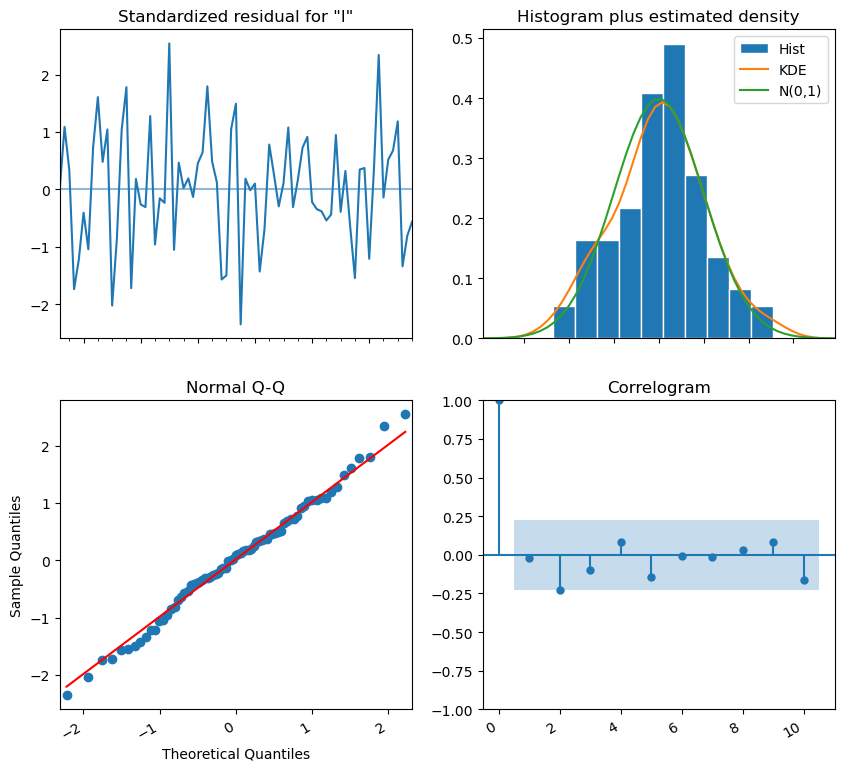

In [46]:
sarima1.plot_diagnostics(figsize=(10, 10))
plt.gcf().autofmt_xdate()
plt.show()

**`Observaciones:`**
+ Se pueden ver los residuales sin tendencia ni estacionalidad
+ En el histograma se puede ver que los residuales no son muy distintos a una distribución normal, lo cual es muy bueno
+ En la gráfica `Normal Q-Q` podemos ver que los residuales tienen un comportamiento similar a la línea de referencia
+ Los residuales no tienen correlaciones

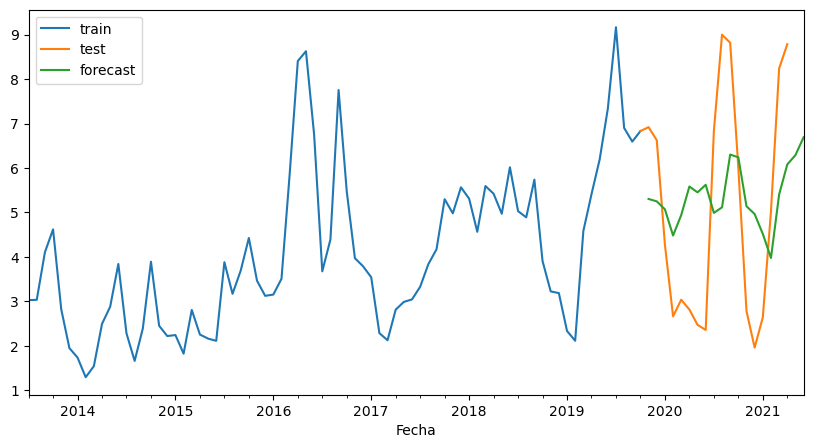

In [47]:
# Predicción
# Pronóstico
y_h = np.exp(sarima1.predict(start=train.shape[0], end=train.shape[0]+test.shape[0], dynamic=False)).to_frame()
fig, ax = plt.subplots(figsize = (10, 5))
train['Promedio'].plot(ax = ax)
test.plot(ax = ax)
y_h.plot(ax = ax)
ax.legend(labels = ['train', 'test', 'forecast'])
plt.show()

___
## <font color='maroon'> Parte Univariada con Deep Learning </font>

In [13]:
# Para la parte univariada solo con la variable del promedio.
df = data_prod[["Promedio"]]
obj = NN_maker(data=df, n_steps= 7, horizont=14)

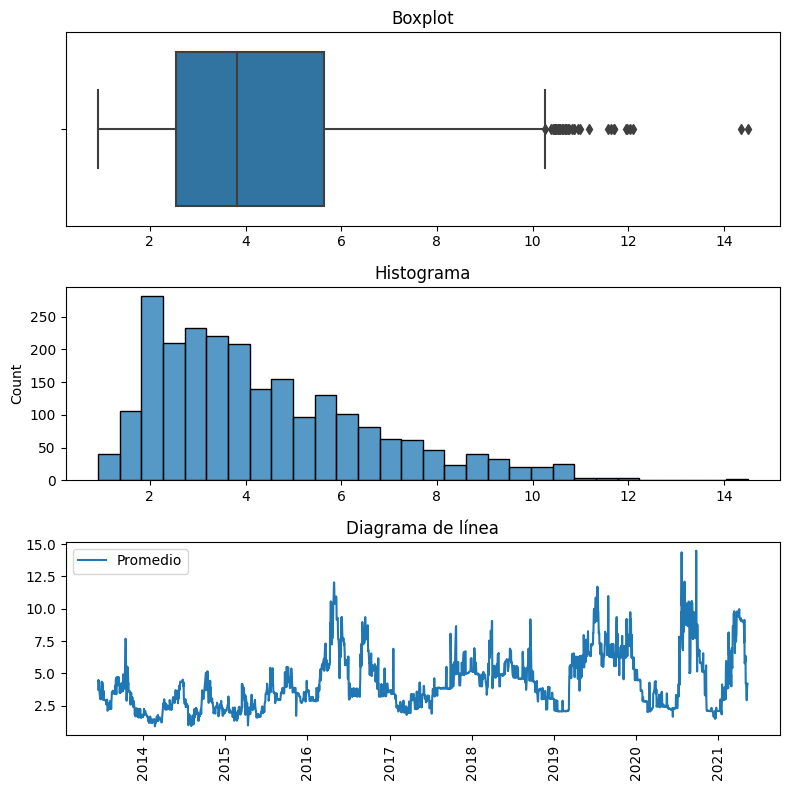

In [14]:
obj.plot_serie()

Al estar tan sesgada la serie, vamos a aplicar un logaritmo, a ver si mejora, ya que tiene una cola positiva, el logaritmo puede tender a mejorar la distribución de los datos.

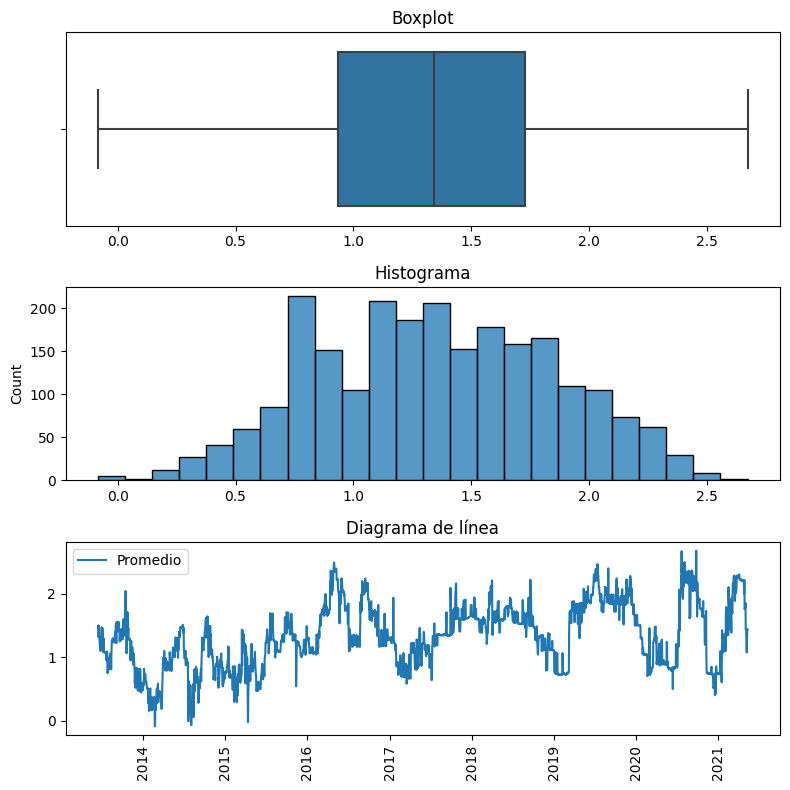

In [15]:
obj.transform_data()
obj.plot_serie()

En efecto ahora hay una distribución mucho más normal, vamos a proceder con el modelado de los datos, primero vamos a hacer un modelo muy simple mlp.

In [16]:
# Separamos los datos en train, val y test
X_train, X_val, X_test, y_train, y_val, y_test= obj.train_val_test_split()

# Imprimir dimensiones de los datos de entrenamiento, validación y test
print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (1870, 7) (1870,)
Datos de validación (227, 7) (227,)
Datos de test (229, 7) (229,)


R2: 0.9253472266619723
MAE: 0.1019659043995045


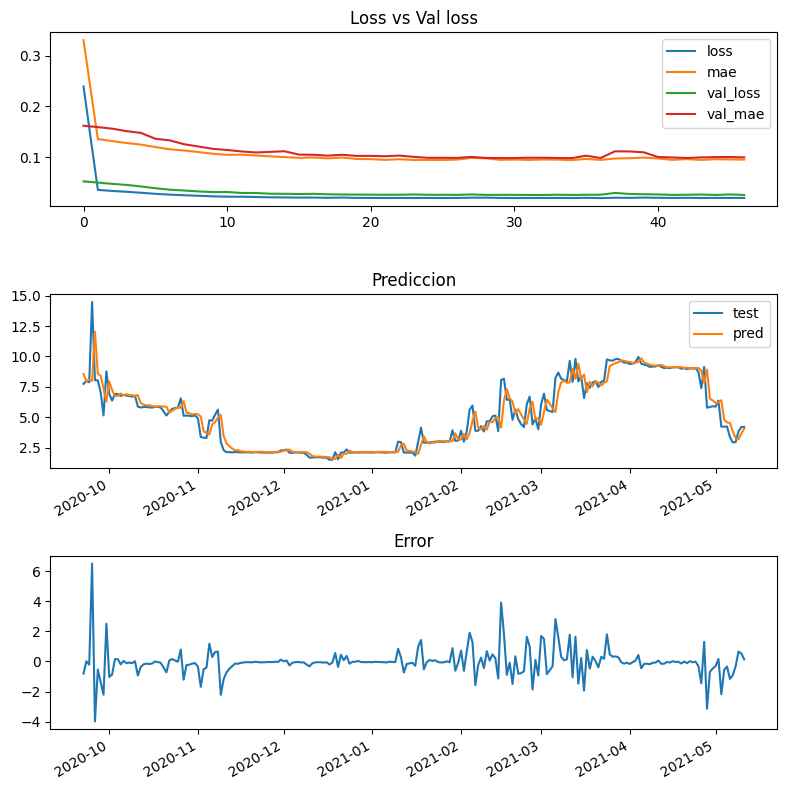

In [18]:
# Ejecutamos un modelo sencillo con solo 1 capa oculta y 32 neuronas
num_hidden_layers = 1
num_neurons = 32
dropout_rate = None

model_mlp_1 = obj.MLP_builder(num_hidden_layers=num_hidden_layers, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                        y_val=y_val, y_test=y_test, num_neurons=num_neurons, log=True, plot=True)

R2: 0.796553242671873
MAE: 0.21533804795085337


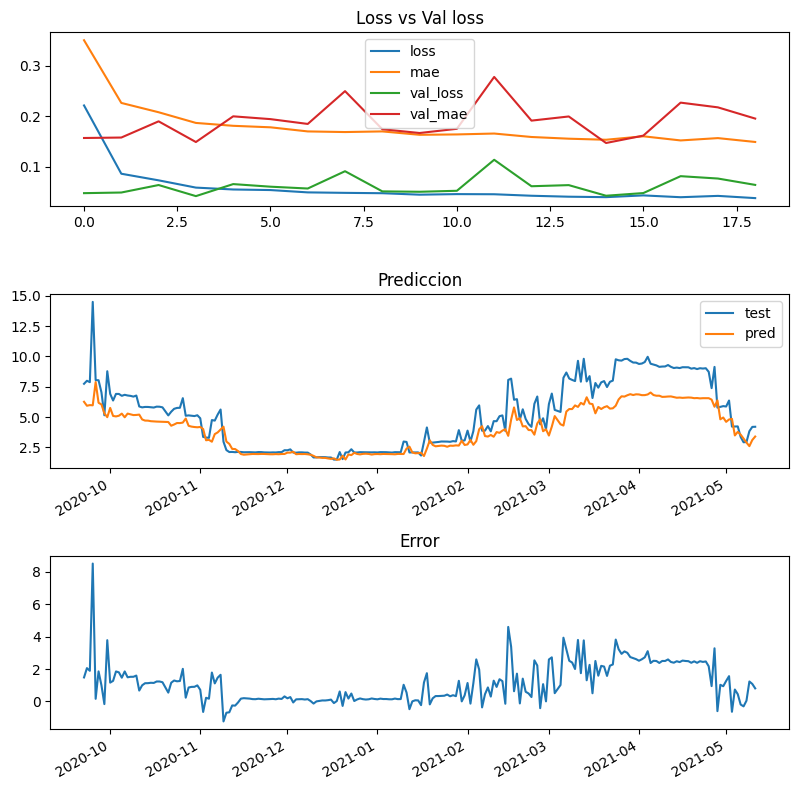

In [21]:
# Ahora corremos con 2 capas ocultas y 64 neuronas, agregamos dropout para evitar overfitting
num_hidden_layers = 2
num_neurons = 64
dropout_rate = 0.2

model_mlp_2 = obj.MLP_builder(num_hidden_layers=num_hidden_layers, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                        y_val=y_val, y_test=y_test, num_neurons=num_neurons, log=True, plot=True, dropout_rate=dropout_rate)

Parece que las capas ocultas evitaron que siga aprendiendo, voy a intentar, dejando el dropout y quitando una oculta.

R2: 0.910061927254655
MAE: 0.13370028002557452


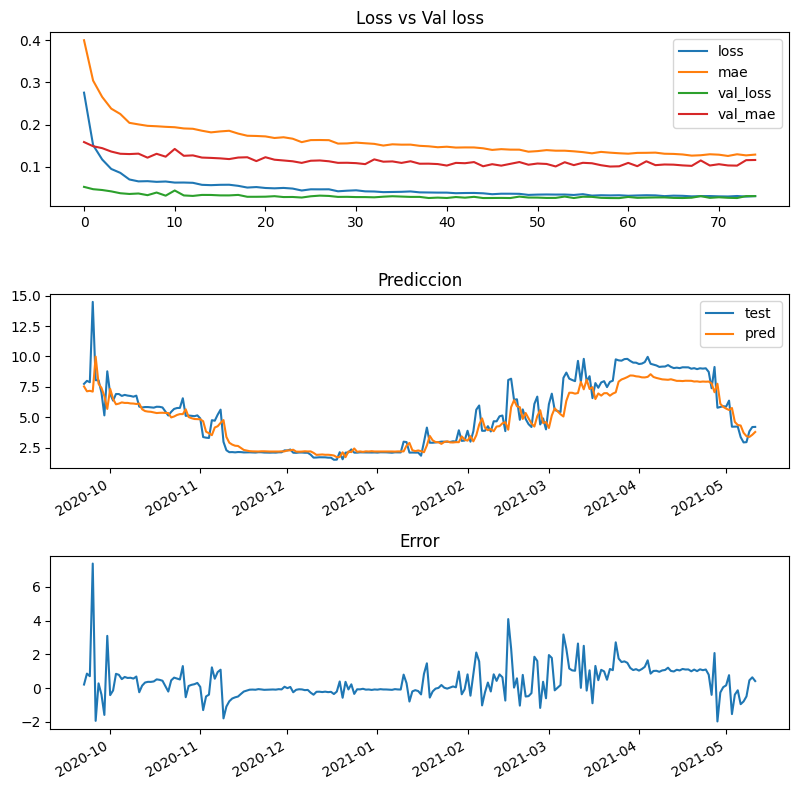

In [22]:
# Vamos a quitar una capa oculta y jugar con el dropout.
num_hidden_layers = 1
num_neurons = 64
dropout_rate = 0.2

model_mlp_3 = obj.MLP_builder(num_hidden_layers=num_hidden_layers, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                        y_val=y_val, y_test=y_test, num_neurons=num_neurons, log=True, plot=True, dropout_rate=dropout_rate)

### <font color='teal'> CNN </font>

In [23]:
# Separamos en train, val y test. y reordenamos en forma tensorial con el parametro conv.
X_train, X_val, X_test, y_train, y_val, y_test = obj.train_val_test_split(conv=True)

# Imprimir dimensiones de los datos de entrenamiento, validación y test
print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (1870, 7, 1) (1870, 1)
Datos de validación (227, 7, 1) (227, 1)
Datos de test (229, 7, 1) (229, 1)


R2: 0.921962784835108
MAE: 0.10596529953442069


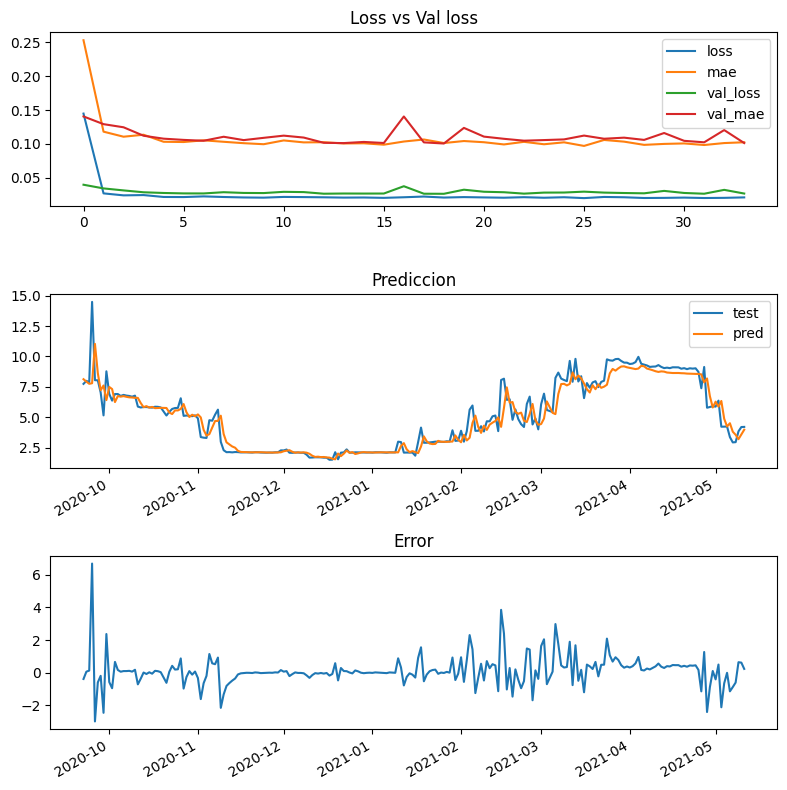

In [24]:
# Ejecutamos nuestra primer red, solo una capa oculta
num_hidden_layers = 1
num_neurons = 256
num_filters = 64
kernel_size = 2

model_cnn_1 = obj.cnn_builder(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons,
                                    num_filters=num_filters, kernel_size=kernel_size, pool_size=2,
                                    X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train,
                                    y_val=y_val, y_test=y_test, plot=True, log=True)

R2: 0.9205776388643304
MAE: 0.10722279772086331


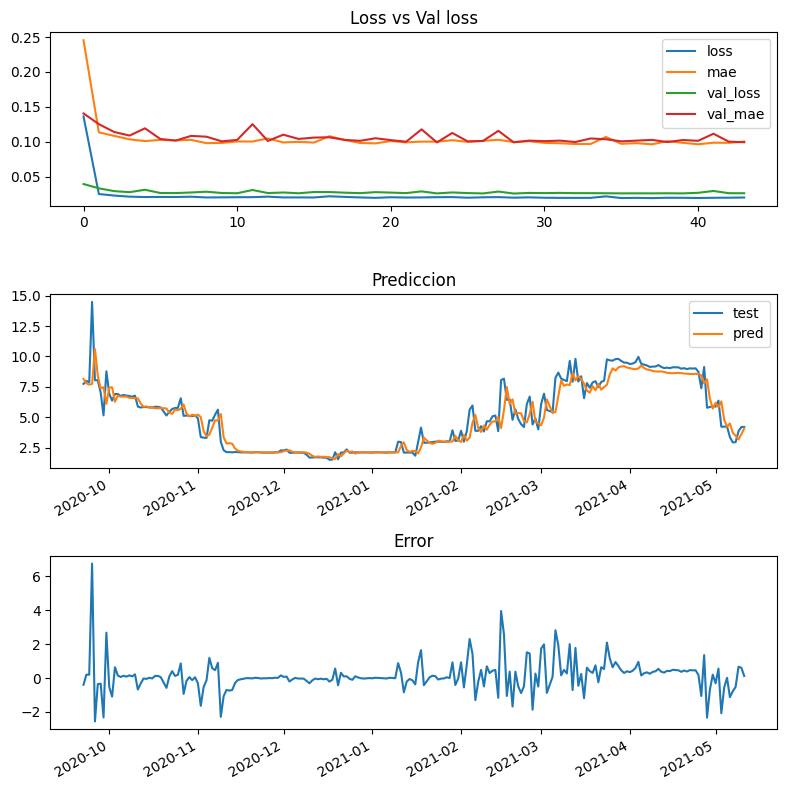

In [26]:
# Dió muy buen resultado, pero los picos todavía no me convencen
num_hidden_layers = 1
num_neurons = 256
num_filters = 64
kernel_size = 2

model_cnn_2 = obj.cnn_builder(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons,
                                    num_filters=num_filters, kernel_size=kernel_size, pool_size=2,
                                    X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train,
                                    y_val=y_val, y_test=y_test, plot=True, log=True)

R2: 0.9220644808430766
MAE: 0.10606743831657234


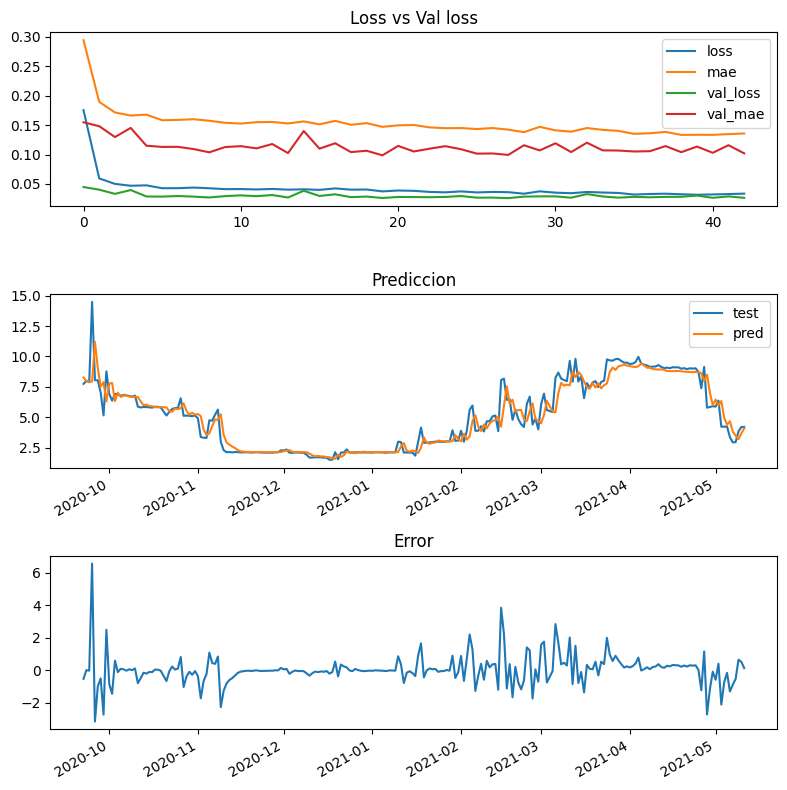

In [28]:
# veamos si el dropout hace algun buen efecto en la red
num_hidden_layers = 1
num_neurons = 256
num_filters = 64
kernel_size = 2
dropout_rate = 0.5

model_cnn_3 = obj.cnn_builder(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons,
                                    num_filters=num_filters, kernel_size=kernel_size, pool_size=2,
                                    X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train,
                                    y_val=y_val, y_test=y_test, dropout_rate=dropout_rate, plot=True, log=True)

### <font color='teal'>LSTM </font>

R2: -0.5941220147106221
MAE: 0.5813601425467372


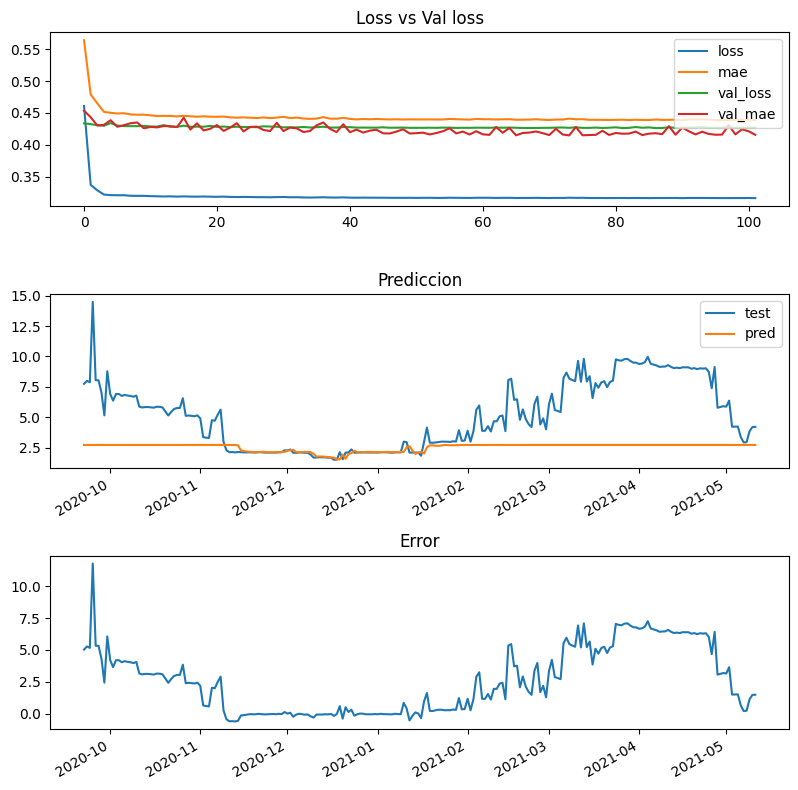

In [29]:
units_lstm = 50
capas_ocultas_dense = 1
units_dense = 32

model_lstm_1 = obj.lstm_builder(units_lstm=units_lstm, capas_ocultas_lstm=1, capas_ocultas_dense=capas_ocultas_dense, 
                                     units_dense=units_dense, X_train = X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                                     y_val=y_val, y_test=y_test, plot=True, dropout=None, log=True)

Modelo muy malo, vamos a ver si con otros parámetros puede mejorar.

R2: -0.592990467940627
MAE: 0.5803133654003897


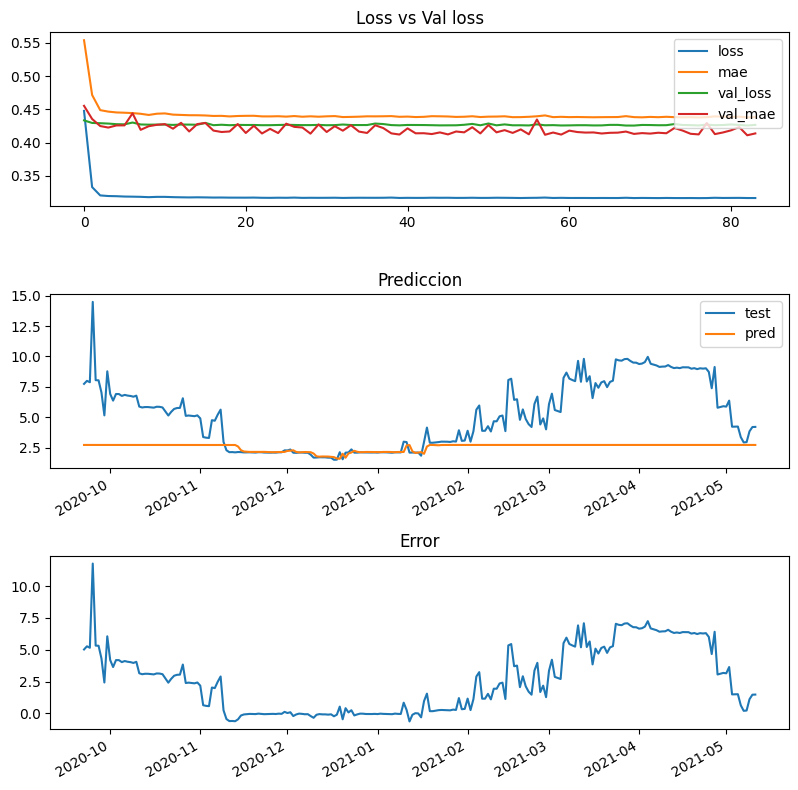

In [30]:
# Pesimo modelo, vamos agregando más parámetros
units_lstm = 50
capas_ocultas_dense = 3
units_dense = 128

model_lstm_2 = obj.lstm_builder(units_lstm=units_lstm, capas_ocultas_lstm=1, capas_ocultas_dense=capas_ocultas_dense, 
                                     units_dense=units_dense, X_train = X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, 
                                     y_test=y_test, plot=True, dropout=None, log=True)

R2: -0.6596539628990341
MAE: 0.6423198467338158


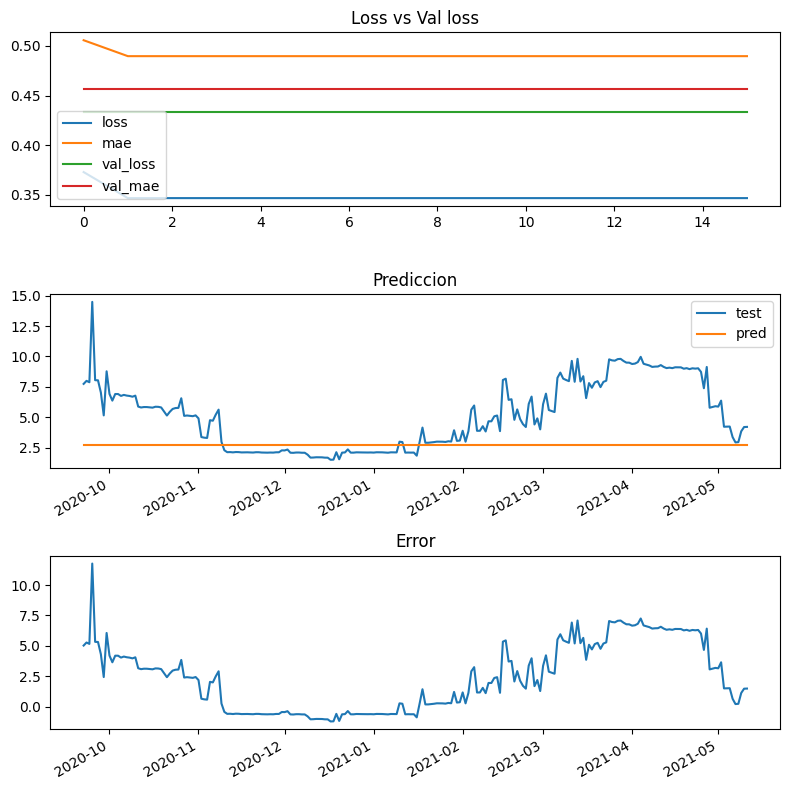

In [31]:
# Vamos a ver si con más unidades lstm se puede mejorar el modelo
units_lstm = 500
capas_ocultas_dense = 5
units_dense = 526

model_lstm_3 = obj.lstm_builder(units_lstm=units_lstm, capas_ocultas_lstm=1, capas_ocultas_dense=capas_ocultas_dense, 
                                     units_dense=units_dense, X_train = X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, 
                                     y_test=y_test, plot=True, dropout=None, log=True)

### <font color='teal'> CNN-LSTM </font>

In [16]:
# Separamos en train, val y test. y reordenamos en forma tensorial con el parametro conv.
X_train, X_val, X_test, y_train, y_val, y_test = obj.train_val_test_split(conv=True)

n_features = 1
n_seq = 1
n_steps = 7
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_val = X_val.reshape((X_val.shape[0], n_seq, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (1870, 1, 7, 1) (1870, 1)
Datos de validación (227, 1, 7, 1) (227, 1)
Datos de test (229, 1, 7, 1) (229, 1)


R2: 0.8785068153126773
MAE: 0.14609314122112668


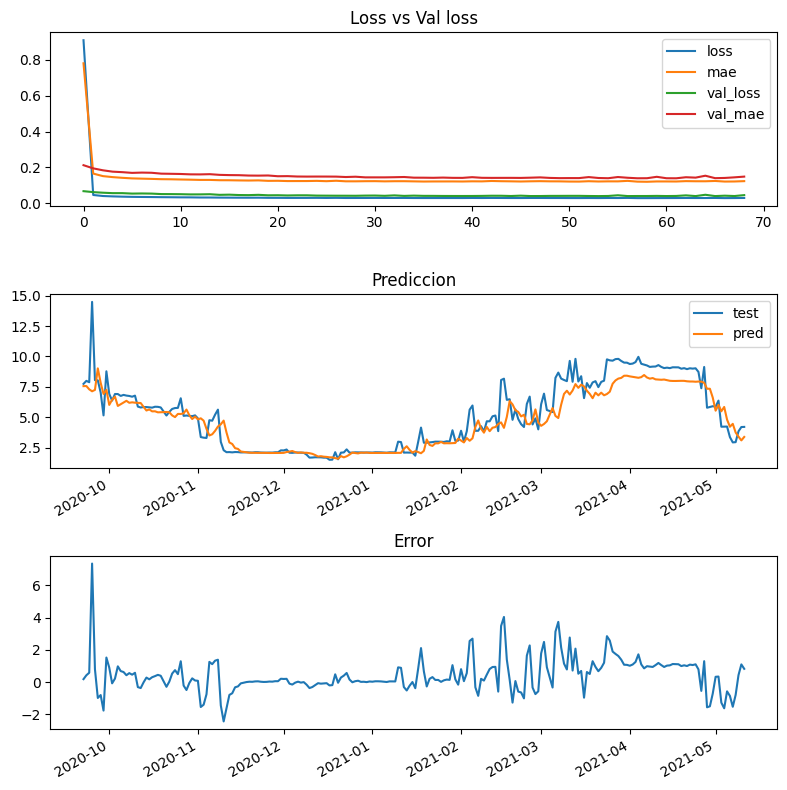

In [17]:
# Empezamos 
blocks = 1
filters = 10
units_lstm = 30

model_cnn_lstm_1 = obj.cnn_lstm_builder(blocks=blocks, filters=filters, units_lstm=units_lstm,  X_train=X_train, X_val=X_val, 
                                             X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, plot=True, 
                                             dropout=None, log=True)

R2: 0.8880052742958127
MAE: 0.1300085731390494


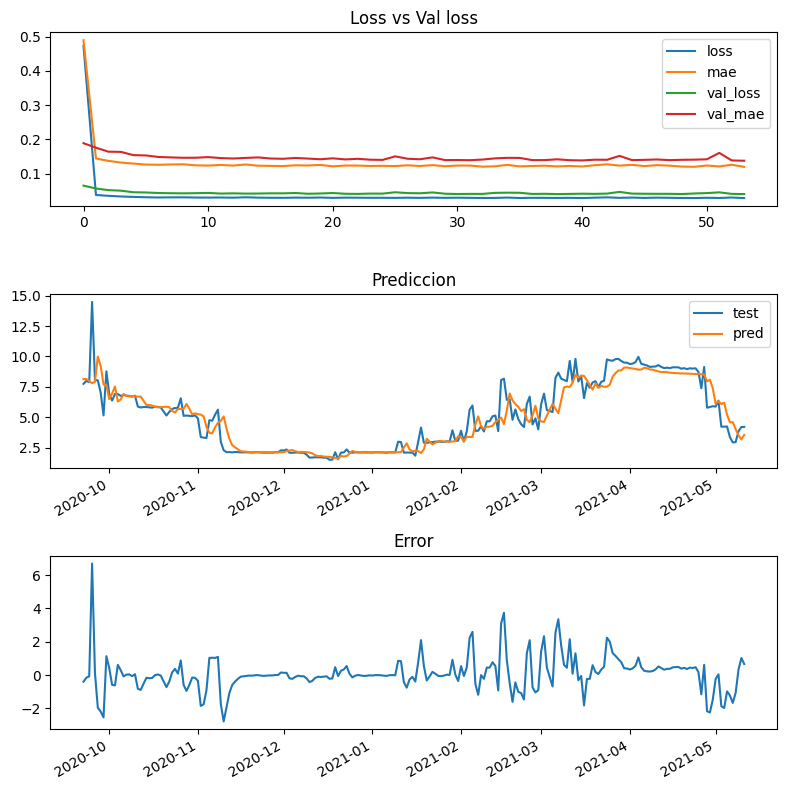

In [19]:
blocks = 1
filters = 40
units_lstm = 50

model_cnn_lstm_2 = obj.cnn_lstm_builder(blocks=blocks, filters=filters, units_lstm=units_lstm,  X_train=X_train, X_val=X_val, 
                                             X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, plot=True, 
                                             dropout=None, log=True)

R2: 0.8835982630646074
MAE: 0.13590225830505073


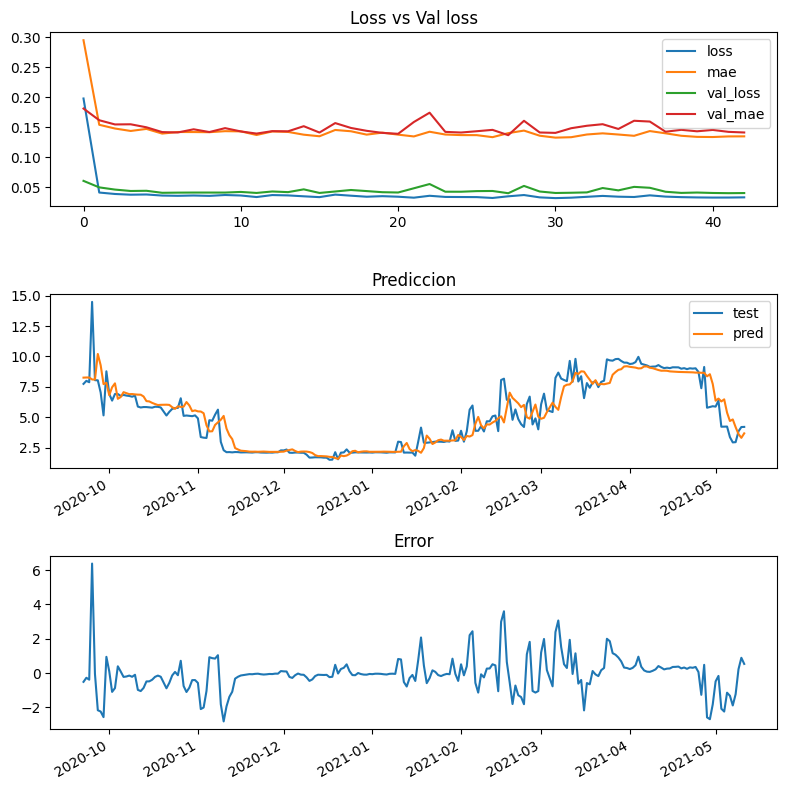

In [20]:
blocks = 1
filters = 256
dropout_rate = 0.2
units_lstm = 100

model_cnn_lstm_3 = obj.cnn_lstm_builder(blocks=blocks, filters=filters, units_lstm=units_lstm,  X_train=X_train, X_val=X_val, 
                                             X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, plot=True, 
                                             dropout=dropout_rate, log=True)

El mejor modelo conseguido fue una CNN, vamos a hacer un optuna con esa arquitectura.

In [25]:
from tensorflow.keras.layers import Dense, MaxPooling1D, Dropout, Conv1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow import keras
import optuna

# Separamos los datos en train, val y test
X_train, X_val, X_test, y_train, y_val, y_test= obj.train_val_test_split(conv=True)


def objective(trial):
    # Definir los hiperparámetros que queremos optimizar
    filters = trial.suggest_int("filters", 32, 128)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    dense_size = trial.suggest_int("dense_size", 64, 256)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Construir el modelo con los hiperparámetros elegidos
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dense(1))

    # Compilar el modelo con el optimizador y la función de pérdida
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Entrenar el modelo y obtener las predicciones
    history = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=256,
            epochs=200,
            verbose=False)
    val_loss = history.history['val_loss'][-1]
    return val_loss

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados
print('Best trial:', study.best_trial.params)
print('Best validation loss:', study.best_trial.value)

[I 2023-05-08 14:37:37,861] A new study created in memory with name: no-name-de6be1f4-c45a-4bfc-abba-4952d81862f6
[I 2023-05-08 14:38:09,879] Trial 0 finished with value: 0.18222744762897491 and parameters: {'filters': 123, 'dropout': 0.34774377053456396, 'dense_size': 231, 'learning_rate': 0.0010004186964755065}. Best is trial 0 with value: 0.18222744762897491.
[I 2023-05-08 14:38:38,130] Trial 1 finished with value: 0.23608481884002686 and parameters: {'filters': 117, 'dropout': 0.43792050098226565, 'dense_size': 166, 'learning_rate': 0.0005815326989089515}. Best is trial 0 with value: 0.18222744762897491.
[I 2023-05-08 14:39:04,187] Trial 2 finished with value: 0.2778153419494629 and parameters: {'filters': 72, 'dropout': 0.4689176715595162, 'dense_size': 246, 'learning_rate': 5.807026684886073e-05}. Best is trial 0 with value: 0.18222744762897491.
[I 2023-05-08 14:39:30,131] Trial 3 finished with value: 0.19095176458358765 and parameters: {'filters': 78, 'dropout': 0.44021927823125

Best trial: {'filters': 97, 'dropout': 0.20694595818553246, 'dense_size': 189, 'learning_rate': 0.0068903542803917615}
Best validation loss: 0.05588889867067337


In [30]:
# Imprimimos los mejores parámetros
dict_params = study.best_params
dict_params

{'filters': 97,
 'dropout': 0.20694595818553246,
 'dense_size': 189,
 'learning_rate': 0.0068903542803917615}

R2: 0.9204915033526033
MAE: 0.10912021591982411


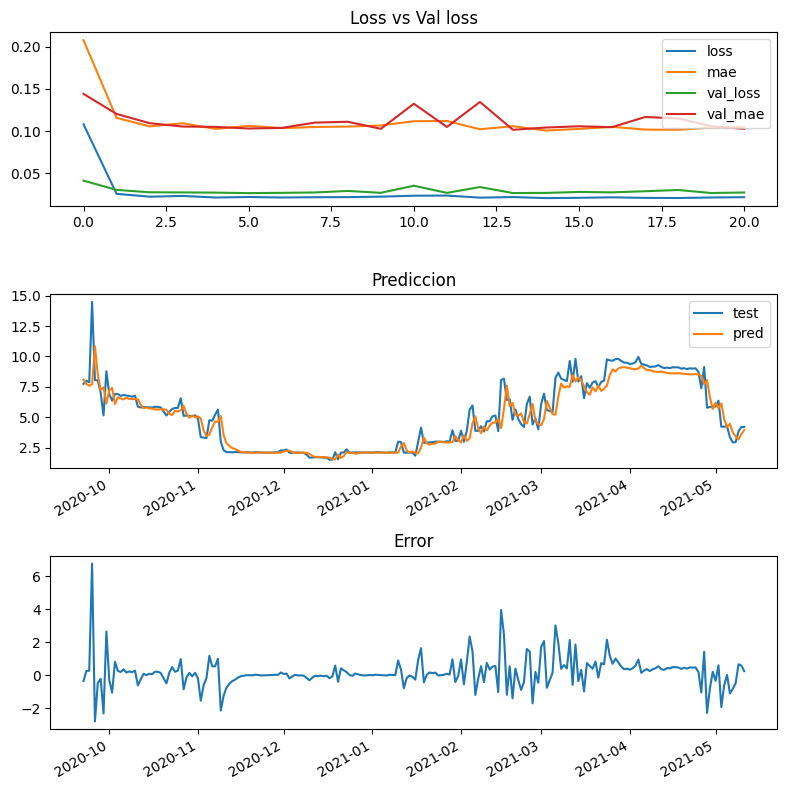

In [40]:
# Ejecutamos nuestra red con datos optimizados
dense_size = dict_params["dense_size"]
dropout = dict_params["dropout"]
filters = dict_params["filters"]
lr = dict_params["learning_rate"]

# Construir el modelo con los hiperparámetros elegidos
model = Sequential()
model.add(Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(dense_size, activation='relu'))
model.add(Dense(1))

# Compilar el modelo con el optimizador y la función de pérdida
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse')

obj.train_models(model=model, X_train=X_train, X_val=X_val, X_test=X_test, 
                 y_train=y_train, y_val=y_val, y_test=y_test, log=True, plot=True)

Pues salió bastante parecido el resultado del modelo solo que con menos neuronas, filtros, etc. Entonces se puede considerar que nos funcionó el optuna.

___
## <font color='maroon'> Parte Multivariada con Deep Learning </font>
### Creación del dataset
- Al tener datos que contiene las variables de Mínimo, Inflación, Precio del Dolar y Porcentaje de Desempelo para predecir el precio promedio del producto tenemos que crear el dataset de manera que las variables predictoras sean del día anterior al que se quiere predecir.
    - Es decir, si queremos predecir el precio promedio del producto para el día 2021-06-01, las variables predictoras serán las del día 2021-05-31.
- Se decidió hacer una ventana de 7, al tener datos diarios hacemos que nuestras ventanas de tiempo sean semanales y podamos realizar un mejor uso de los datos.
- Las variables:
    - Inflación y Porcentaje de Desempleo: parecieran que son estaticas, sin embargo al tener temporalidad más grande no afectan mucho a la predicción.
    - Mínimo y Precio del Dolar: son las variables que más afectan a la predicción, ya que son las que más varían en el tiempo y afectan directamente al precio promedio del producto.

In [9]:
# Filtramos el dataset para quedarnos solo con el producto que queremos predecir
data_prod_multi = data[data['Producto'] == producto]
# Eliminando fechas
data_prod_multi = data_prod_multi.drop(['2013-06-16', '2013-06-17', '2013-06-18', '2013-06-19', '2013-06-20', '2013-06-21',
                                        '2013-06-25', '2013-06-26', '2013-06-27', '2013-06-28', '2013-06-30', '2021-05-01',
                                        '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07',
                                        '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11'])

# Tomamos las 3 variables que se usarán como predictores y la de respuesta
data_multi = data_prod_multi[['Mínimo', 'Inflacion', 'Precio_Dolar', 'Desempleo', 'Promedio']]
# Desplazamos las variables predictoras 1 día
data_multi[['Mínimo', 'Inflacion', 'Precio_Dolar', 'Desempleo']] = data_multi[['Mínimo', 'Inflacion', 'Precio_Dolar', 'Desempleo']].shift(1)
# Quitando nulos
data_multi = data_multi.dropna()
# Convertimos el dataframe a un array
data_multi = data_multi.values
# Mostrando los tamaños
print(f'Forma del array: \n- {data_multi.shape}\n')
print(f'Primeros 5 elementos del array: \n{data_multi[:5]}')

Forma del array: 
- (2324, 5)

Primeros 5 elementos del array: 
[[ 2.7109  9.04   92.883  10.5     4.3603]
 [ 4.0249  9.04   94.579  10.5     3.6449]
 [ 3.3135  9.04   94.926  10.5     3.5999]
 [ 3.2726  9.04   95.97   10.5     4.3029]
 [ 3.9719  9.04   96.019  10.5     2.9398]]


In [10]:
# Dividiendo en X e y, además de tomar un n-steps de 7 para que sea semanal
X, y = split_multivariate_sequence(data_multi, 7)

# Dividiendo en train y test
X_train, X_test, y_train, y_test = train_test_split_multi(X=X, 
                                                          y=y,
                                                          train=0.8)

Forma de X: (2318, 7, 4)
Forma de y: (2318, 1)
Entrenamiento:
- X: (1854, 7, 4)
- y: (1854, 1)

Prueba:
- X: (464, 7, 4)
- y: (464, 1)


### <font color='teal'> MLP </font>

15/15 [==============================] - 1s 3ms/step
El último estado de la métrica mae es: 0.5334
El R2 del modelo es: 0.8902


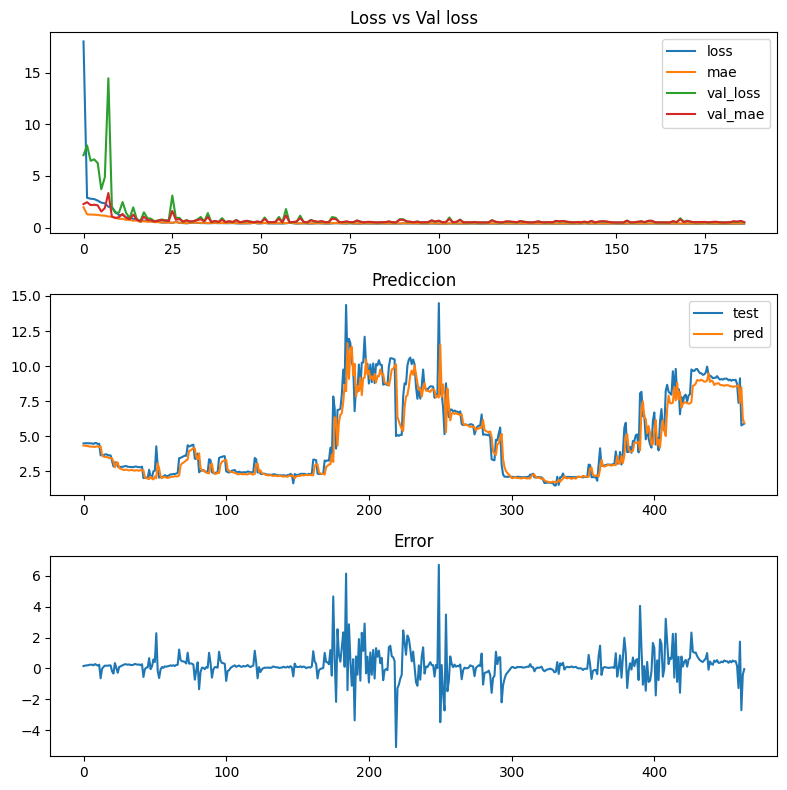

In [11]:
# Creando el modelo de MLP con 6 capas ocultas y 64 neuronas por capa
model_mlp_multi, history_mlp_mlti = gen_MLP_model(X=X_train, y=y_train, val_split=0.2, input_shape=(X_train.shape[1], X_train.shape[2]),
                                                  activation='relu', num_layers=6, num_neurons=64,
                                                  optimizer='Adagrad', lr=0.01, loss='mse', metrics=['mae'],
                                                  patience=25, epochs=500, verbose=0,
                                                  X_test=X_test, y_test=y_test, index=np.arange(0, 464),
                                                  plot_history=True
                                                  )

### <font color='teal'> CNN </font>

15/15 [==============================] - 1s 5ms/step
El último estado de la métrica mae es: 0.5029
El R2 del modelo es: 0.8899


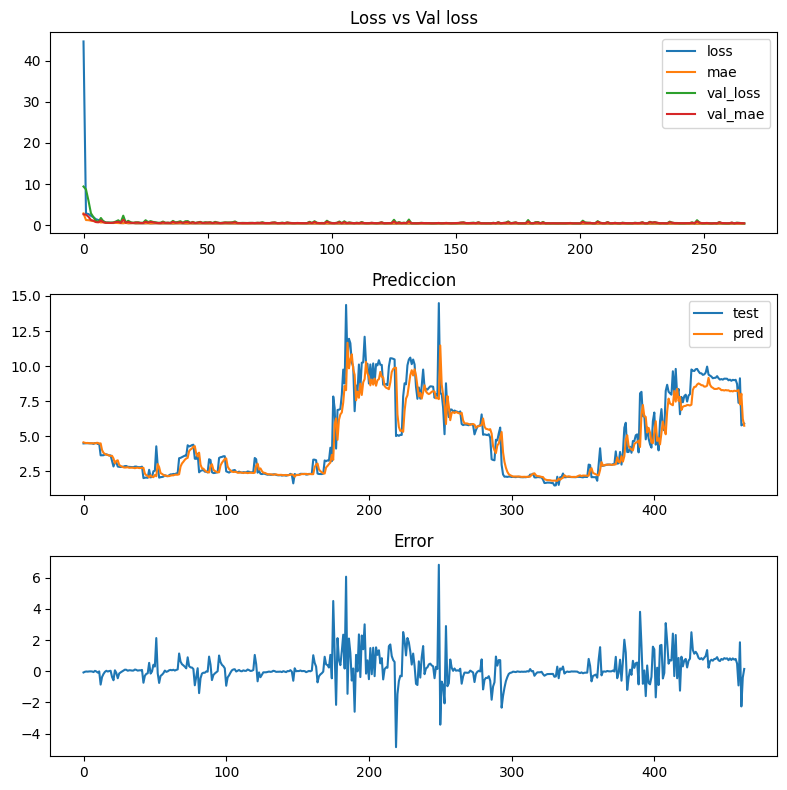

In [12]:
# Creando el modelo de CNN con 5 capas de convolución con 128 filtros y 5 capas densas con 100 neuronas
model_cnn_multi, history_cnn_multi = gen_CNN_model(X=X_train, y=y_train, val_split=0.2, input_shape=(X_train.shape[1], X_train.shape[2]),
                                                    num_layers_cnn=5, num_filters=128, kernel_size=4, padding='same',
                                                    activation='relu', num_layers_dense=5, num_neurons=100,
                                                    optimizer='Adagrad', lr=0.01, loss='mse', metrics=['mae'],
                                                    patience=25, epochs=500, verbose=0,
                                                    X_test=X_test, y_test=y_test, index=np.arange(0, 464),
                                                    plot_history=True
                                                    )

### <font color='teal'> LSTM </font>

15/15 [==============================] - 2s 27ms/step
El último estado de la métrica mae es: 0.7585
El R2 del modelo es: 0.772


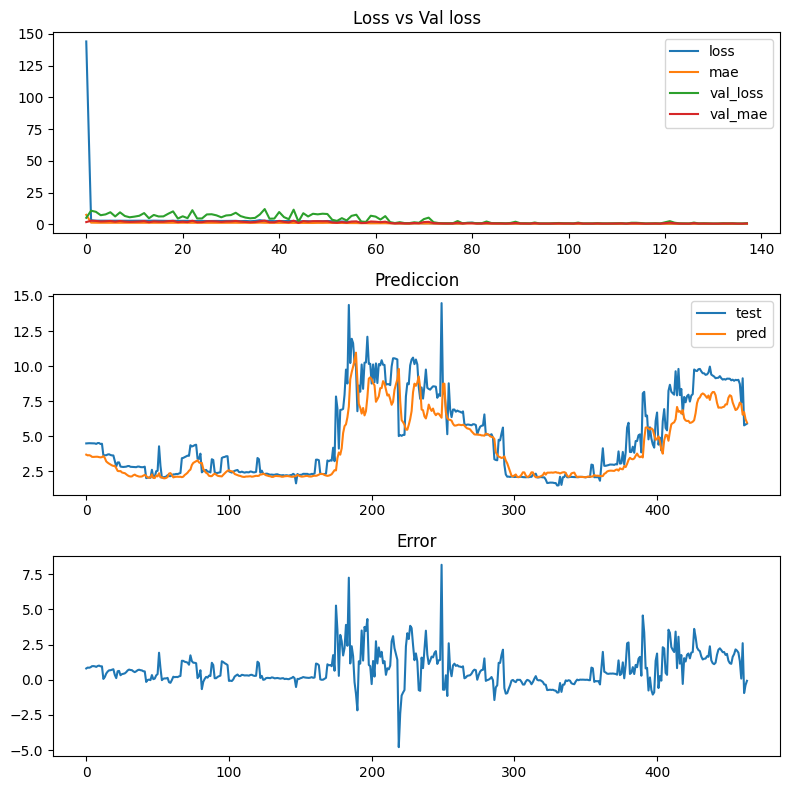

In [13]:
# Creando el modelo de LSTM con 5 capas de LSTM con 100 unidades y 5 capas densas con 100 neuronas
model_lstm_multi, history_lstm_multi = gen_LSTM_model(X=X_train, y=y_train, val_split=0.2, input_shape=(X_train.shape[1], X_train.shape[2]),
                                                      num_layers_lstm=5, activation_lstm='relu', num_units_lstm=100, bidireccional=True,
                                                      activation='relu', num_layers_dense=5, num_neurons=100,
                                                      optimizer='Adagrad', lr=0.01, loss='mse', metrics=['mae'],
                                                      patience=25, epochs=500, verbose=0,
                                                      X_test=X_test, y_test=y_test, index=np.arange(0, 464),
                                                      plot_history=True
                                                      )

### <font color='teal'> CNN-LSTM </font>

15/15 [==============================] - 2s 23ms/step
El último estado de la métrica mae es: 2.666
El R2 del modelo es: -0.1346


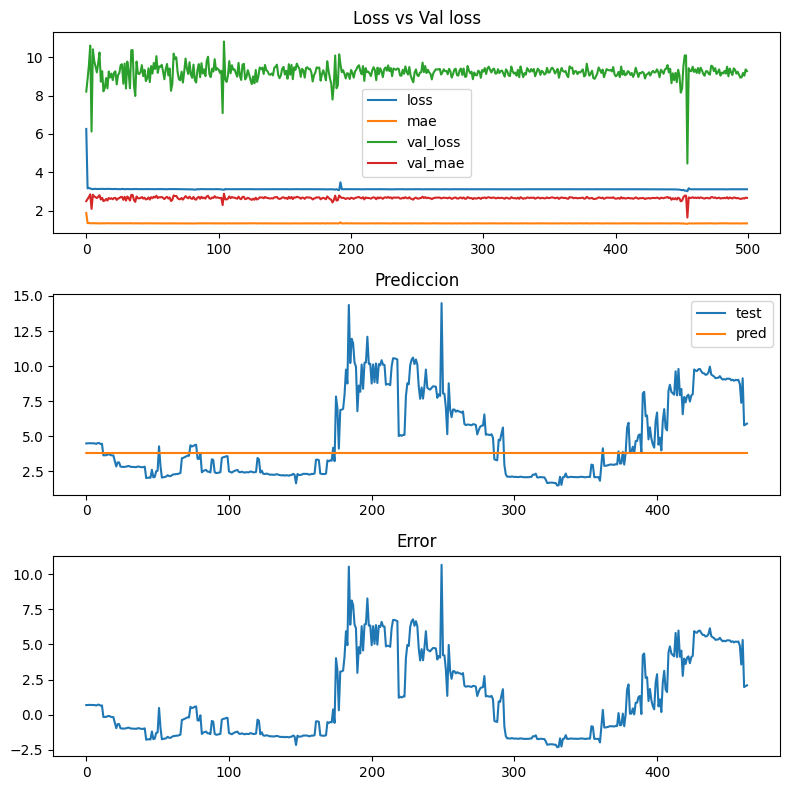

In [14]:
model_cnn_lstm_multi, history_cnn_lstm_multi = gen_CNN_LSTM_model(X=X_train, y=y_train, val_split=0.2, input_shape=(X_train.shape[1], X_train.shape[2]),
                                                                  num_layers_cnn=5, num_filters=128, kernel_size=4, padding='same',
                                                                  num_layers_lstm=5, activation_lstm='relu', num_units_lstm=100,
                                                                  activation='relu', num_layers_dense=5, num_neurons=100,
                                                                  optimizer='Adagrad', lr=0.01, loss='mse', metrics=['mae'],
                                                                  patience=0, epochs=500, verbose=0,
                                                                  X_test=X_test, y_test=y_test, index=np.arange(0, 464),
                                                                  plot_history=True
                                                                  )

### <font color='teal'> Conclusiones </font>
- Modelos encontrados:
    - El mejor modelo encontrado es el MLP con $0.89$ de $R^2$.
    - El segundo mejor modelo encontrado la CNN con $0.88$ de $R^2$.
- Selección del Modelo
    - Se selecciona el modelo de MLP, ya que el tiempo de entrenamiento es mucho menor que el de CNN (aprox. 5.5 veces más) y tuvo un mejor rendimiento.

___
## <font color='maroon'> Clasificación de Series </font>
### <font color='maroon'> Preparación Dataset </font>
- En este paso se realizará el procesamiento para lograr la clasificación de las series de tiempo

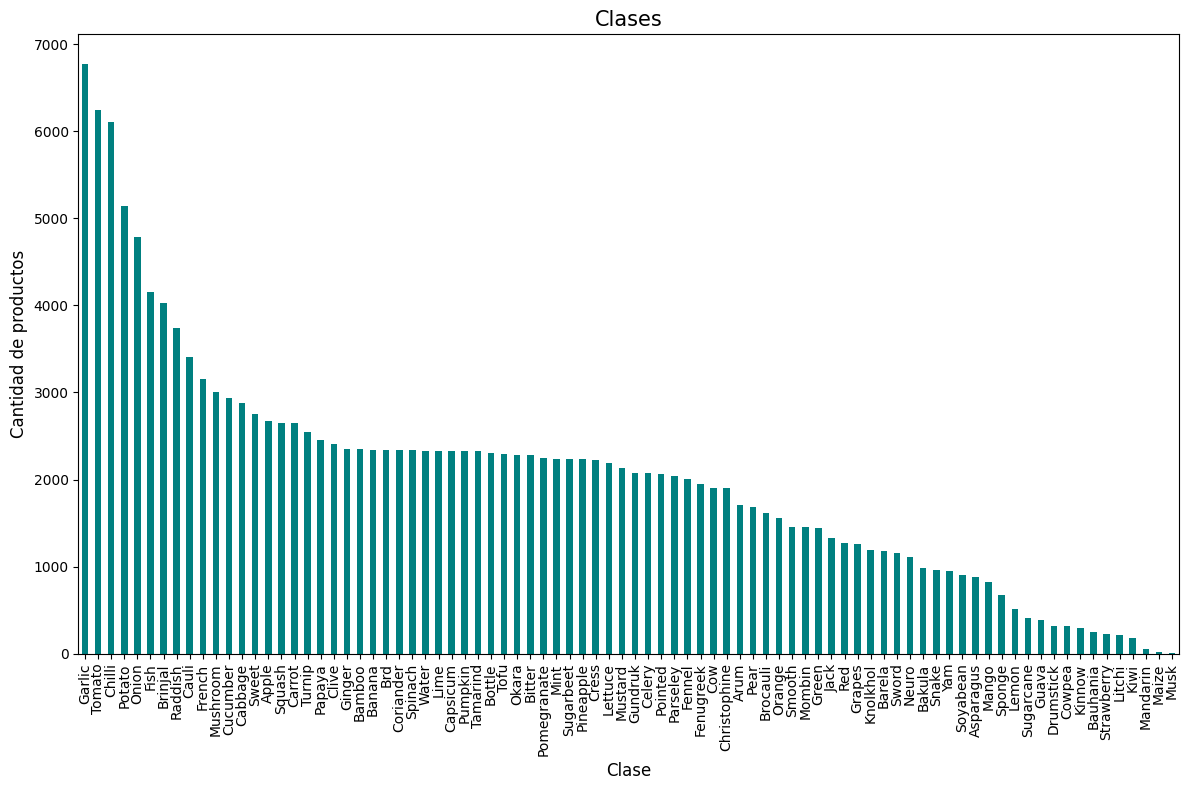

Hay 84 clases de productos distintas.


In [9]:
# Ver las clases existentes
data['Clase'].value_counts().plot(kind='bar', figsize=(12, 8), color='teal')
plt.title('Clases', fontsize=15)
plt.ylabel('Cantidad de productos', fontsize=12)
plt.xlabel('Clase', fontsize=12)
plt.tight_layout()
plt.show()

# Conteo
print(f'Hay {data["Clase"].nunique()} clases de productos distintas.')

Debido a que son demasiadas clases y están imbalanceadas, se agruparán los productos en $3$ distintas clasificaciones:
+ Frutas
+ Verduras
+ Otros

In [10]:
# Diccionario con las clases
dict_clases = {0: 'Others', 1: 'Fruits', 2: 'Veggies'}

# Obteniendo las nuevas categorías
data = get_categories(data)
# Mostrando
data.head()

,Producto,Promedio,y
Fecha,,,
2013-06-16,Apple(Jholey),15.0421,1
2013-06-16,Asparagus,17.0933,2
2013-06-16,Bamboo Shoot,7.5211,0
2013-06-16,Banana,10.2560,1
2013-06-16,Bitter Gourd,2.0512,0


In [11]:
# Obteniendo las longitudes de las series de tiempo
products_ts = {}
for prod in data['Producto'].unique():
    products_ts[prod] = [np.array(data.loc[data.Producto==prod]['Promedio']), data.loc[data.Producto==prod]['y'][0]]

# Ver las diferentes longitudes de las series de tiempo
lens = []
for values in products_ts.values():
    lens.append(len(values[0]))

# Mostrando cantidad de longitudes diferentes que tenemos
print(f'Hay {len(set(lens))} longitudes diferentes de series de tiempo.')

Hay 121 longitudes diferentes de series de tiempo.


 + Frutas: 45 
 + Verduras: 52 
 + Otros: 35


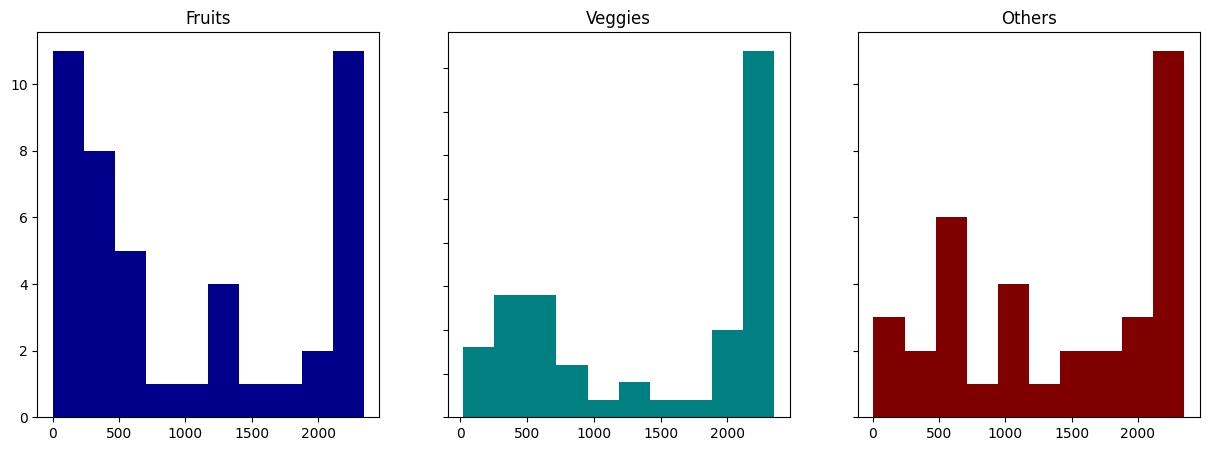

In [12]:
# Obteniendo la cantidad de productos por longitud de serie de tiempo de cada clase
plot_length_ts(products_ts)

- Al tener series con longitudes diferentes se realizará un padding para que todas las series tengan la misma longitud.
- Se decidió que la longitud de las series de tiempo sea de 1250 datos, ya que es el punto medio de las 3 distribuciones.
    - Para realizarlo se hará un padding repitiendo el patrón de las series que tengan menos de 1250 datos y se truncarán las series que tengan más de 1250 datos.

In [13]:
# Obteniendo nuestro dataset transformado, con el umbral de 1250
new_data, labels = TransformData(products_ts=products_ts, umbral=1250).apply_transformation()

Forma de los nuevos datos: (132, 1250)
	 - Tenemos 132 series de tiempo
		 - Cada serie de tiempo tiene 1250 datos


In [20]:
# Mostrando 5 ejemplos del nuevo dataset
print(f'Datos X: \n{new_data[:5]}')
print(f'\nDatos y: \n{labels[:5]}')

Datos X: 
[[41.0239 41.2853 40.6388 ... 85.7777 86.3751 85.7284]
 [24.4679 24.8372 24.7617 ... 88.3804 89.6358 88.6463]
 [37.1992 37.7428 37.4127 ... 38.8057 38.8506 38.9391]
 [ 3.9486  3.9389  3.9161 ...  4.4704  4.2276  4.4159]
 [22.7542 22.6455 22.7542 ... 22.6455 22.7542 22.6455]]

Datos y: 
[1. 1. 0. 2. 1.]


In [21]:
# Dividiendo en train y test
X_train, X_test, y_train, y_test = split_data_clasification(data=new_data, labels=labels, test_size=0.2, shuffle=True)

# Lista con las etiquetas
etiquetas =  [dict_clases.get(0), dict_clases.get(1), dict_clases.get(2)]

- Forma de los Datos de Entrenamiento:
	- Forma de los datos de Entrenamiento: (106, 1250)
	- Forma de las etiquetas de Entrenamiento: (106, 1)
- Forma de los Datos de Prueba:
	- Forma de los datos de Prueba: (26, 1250)
	- Forma de las etiquetas de Prueba: (26, 1)


### <font color='maroon'> Clasificación con Machine Learning </font>
#### <font color='teal'> XGBoost </font>

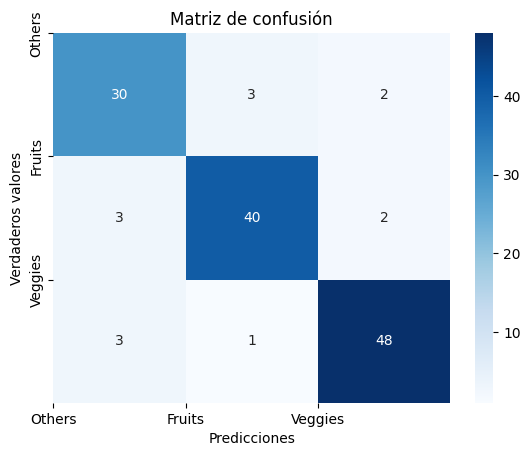

,Modelo,Métricas,Valor
0,XGBoost,Accuracy,0.8939
1,XGBoost,Recall,0.8939
2,XGBoost,Precision,0.8945
3,XGBoost,F1,0.8941


In [22]:
# Crear y ajustar el modelo XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Realizar predicciones con todos los datos
y_pred = xgb_model.predict(new_data)

# Evaluar el modelo
get_evaluation('XGBoost', labels, y_pred, etiquetas) 

#### <font color='teal'> Naive Bayes </font>

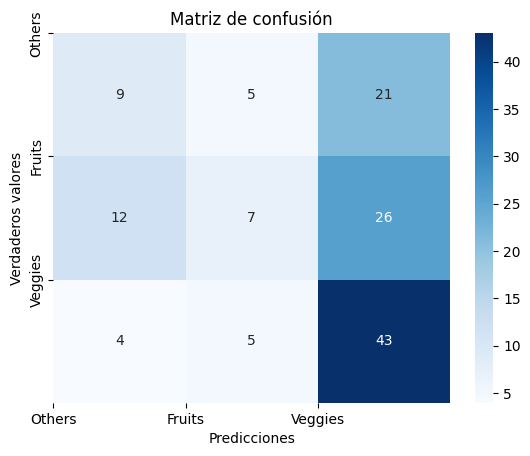

,Modelo,Métricas,Valor
0,Naive Bayes,Accuracy,0.4470
1,Naive Bayes,Recall,0.4470
2,Naive Bayes,Precision,0.4240
3,Naive Bayes,F1,0.3951


In [23]:
# Crear y ajustar el modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Realizar predicciones con todos los datos
y_pred = nb_model.predict(new_data)

# Evaluar el modelo
get_evaluation('Naive Bayes', labels, y_pred, etiquetas)

#### <font color='teal'> Logistic Regression </font>

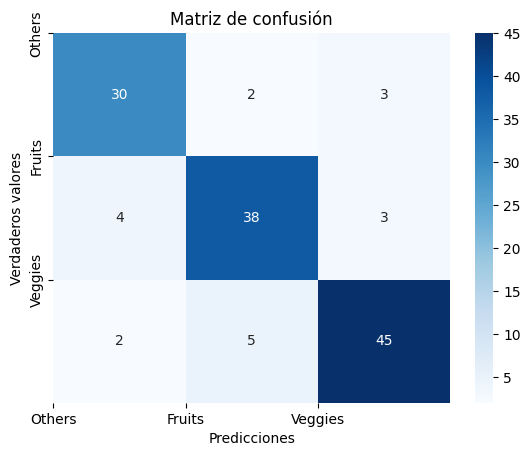

,Modelo,Métricas,Valor
0,Regresión Logística,Accuracy,0.8561
1,Regresión Logística,Recall,0.8561
2,Regresión Logística,Precision,0.8564
3,Regresión Logística,F1,0.8562


In [24]:
# Crear y ajustar el modelo de regresión logística
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Realizar predicciones con todos los datos
y_pred = lr.predict(new_data)

# Evaluar el modelo
get_evaluation('Regresión Logística', labels, y_pred, etiquetas)

#### <font color='teal'> K-Means </font>

In [25]:
# Crea el objeto KMeans
kmeans = KMeans(n_clusters=4)  # Ponemos 4 clústeres, porque sabemos que hay 4 etiquetas
# Ajusta el modelo con tus datos de entrenamiento
kmeans.fit(X_train)

# Predice los clústeres de tus datos de prueba
y_pred = kmeans.predict(X_test)

# Evaluar el modelo
get_evaluation_kmeans('KMeans', X_test, y_pred)

,Modelo,Métrica,Valor
0,KMeans,Coeficiente de Silueta,0.4326


___
## <font color='maroon'> Clasificación con Deep Learning </font>

In [18]:
# Haciendo el vector a one-hot
y_one_hot = to_categorical(labels)

# Dividiendo los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = split_data_clasification(new_data, 
                                                            y_one_hot,
                                                            test_size=0.1, 
                                                            shuffle=True,
                                                            reshape=False)

# Cambiando de one-hot a vector
y_test_eval = np.argmax(y_test, axis=1)
# Lista con las etiquetas
etiquetas =  [dict_clases.get(0), dict_clases.get(1), dict_clases.get(2)]

- Forma de los Datos de Entrenamiento:
	- Forma de los datos de Entrenamiento: (119, 1250)
	- Forma de las etiquetas de Entrenamiento: (119, 3)
- Forma de los Datos de Prueba:
	- Forma de los datos de Prueba: (13, 1250)
	- Forma de las etiquetas de Prueba: (13, 3)


### <font color='teal'> CNN </font>

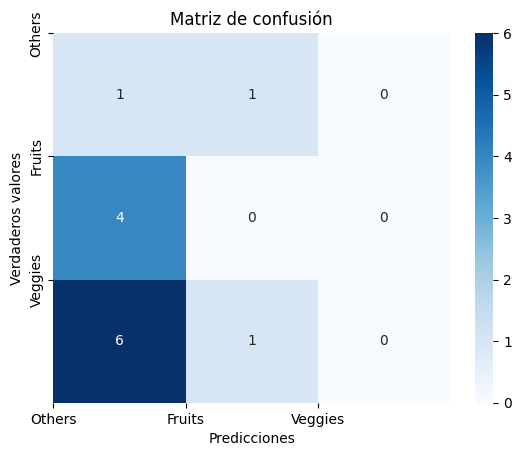

       Modelo   Métricas   Valor
0  Modelo CNN   Accuracy  0.0769
1  Modelo CNN     Recall  0.0769
2  Modelo CNN  Precision  0.0140
3  Modelo CNN         F1  0.0237


In [33]:
# Definir el modelo
model = keras.models.Sequential()
model.add(layers.Input(shape=(X_train.shape[1], 1)))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adadelta(learning_rate=0.0001), 
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=4, 
          validation_split=0.2,
          verbose=0,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy')])


# Obtener las predicciones del modelo
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener la evaluación del modelo
df_eval = get_evaluation('Modelo CNN', y_test_eval, y_pred, etiquetas)
print(df_eval)

### <font color='teal'> LSTM </font>

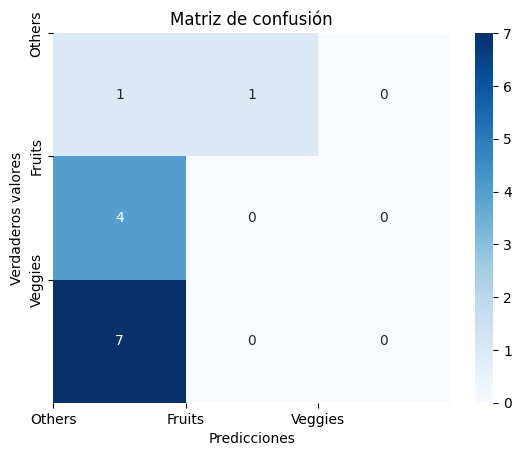

        Modelo   Métricas   Valor
0  Modelo LSTM   Accuracy  0.0769
1  Modelo LSTM     Recall  0.0769
2  Modelo LSTM  Precision  0.0128
3  Modelo LSTM         F1  0.0220


In [34]:
model_lstm = keras.models.Sequential()
model_lstm.add(layers.Input(shape=(X_train.shape[1], 1)))
model_lstm.add(layers.LSTM(units=64, return_sequences=False))
model_lstm.add(layers.Dense(units=32, activation='relu'))
model_lstm.add(layers.Dropout(0.1))
model_lstm.add(layers.Dense(units=16, activation='relu'))
model_lstm.add(layers.Dense(units=3, activation='softmax'))

# Compilación del modelo
model_lstm.compile(loss='categorical_crossentropy', 
                   optimizer=keras.optimizers.Adadelta(learning_rate=0.0001), 
                   metrics=['accuracy'])

# Entrenamiento del modelo
model_lstm.fit(X_train, y_train, 
               epochs=200, 
               batch_size=4, 
               validation_split=0.2,
               verbose=0,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy')])

# Obtener las predicciones del modelo
y_pred_prob_lstm = model_lstm.predict(X_test, verbose=0)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

# Obtener la evaluación del modelo
df_eval_lstm = get_evaluation('Modelo LSTM', y_test_eval, y_pred_lstm, etiquetas)
print(df_eval_lstm)

### <font color='teal'> Conclusiones </font>
+ Para un ejercicio relativamente pocas series de tiempo y una cantidad limitada de productos, conviene más utilizar modelos de aprendizaje supervisado de *Machine Learning* para clasificación; tuvieron mejores resultados que los de *Deep Learning* y que *K-Means*, además de ser menos complejos y tardados computacionalmente.
+ De los modelos probados para clasificación, el mejor fue *XGBoost* con métricas de *Accuracy*, *Precision*, *Recall* y *F1-Score* de casi $0.90$.
+ Para la parte lineal, valdría la pena probar con más modelos e incluso hacer una optimización de hiperparámetros para el SARIMAX, ya que hay muchas posibles combinaciones que no se probaron por cuestión de tiempo.
+ Para la parte univariada, el mejor modelo fue una Red Neuronal Convolucional con una $R^2$ de $0.92$.
+ En cuanto a la parte multivariada, de nuevo el mejor modelo fue la Red Neuronal Convolucional con una $R^2$ de $0.89$.
+ Cuando fue necesario y se transformaron logarítmicamente los datos, fue suficiente para que tengan una distribución normal.